## **Import Packages**

In [2]:
import os
import time
import librosa
import random
import numpy as np
import pandas as pd
import soundfile as sf
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import layers, models 
from keras.callbacks  import ReduceLROnPlateau, EarlyStopping

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from models.deep import NNModel

In [12]:
# seed configuration 
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [13]:
# data path 
DATA_PATH = "ESC-50-master/"
CSV_PATH = os.path.join(DATA_PATH, "meta/esc50.csv")
AUDIO_PATH = os.path.join(DATA_PATH, "audio")
AUGMENTED_PATH = "ESC-50-augmented-data"

## **Load Data**

In [15]:
dataset = pd.read_csv(CSV_PATH)
dataset["files_path"] = dataset["filename"].apply(lambda x: os.path.join(AUDIO_PATH, x))

# ✅ Encode label 
encoder = LabelEncoder()
dataset["target"] = encoder.fit_transform(dataset["category"])
num_classes = len(encoder.classes_)

In [16]:
dataset.head()

filename  fold  target        category  esc10  src_file take  \
0   1-100032-A-0.wav     1      18             dog   True    100032    A   
1  1-100038-A-14.wav     1       7  chirping_birds  False    100038    A   
2  1-100210-A-36.wav     1      46  vacuum_cleaner  False    100210    A   
3  1-100210-B-36.wav     1      46  vacuum_cleaner  False    100210    B   
4  1-101296-A-19.wav     1      43    thunderstorm  False    101296    A   

                              files_path  
0   ESC-50-master/audio\1-100032-A-0.wav  
1  ESC-50-master/audio\1-100038-A-14.wav  
2  ESC-50-master/audio\1-100210-A-36.wav  
3  ESC-50-master/audio\1-100210-B-36.wav  
4  ESC-50-master/audio\1-101296-A-19.wav

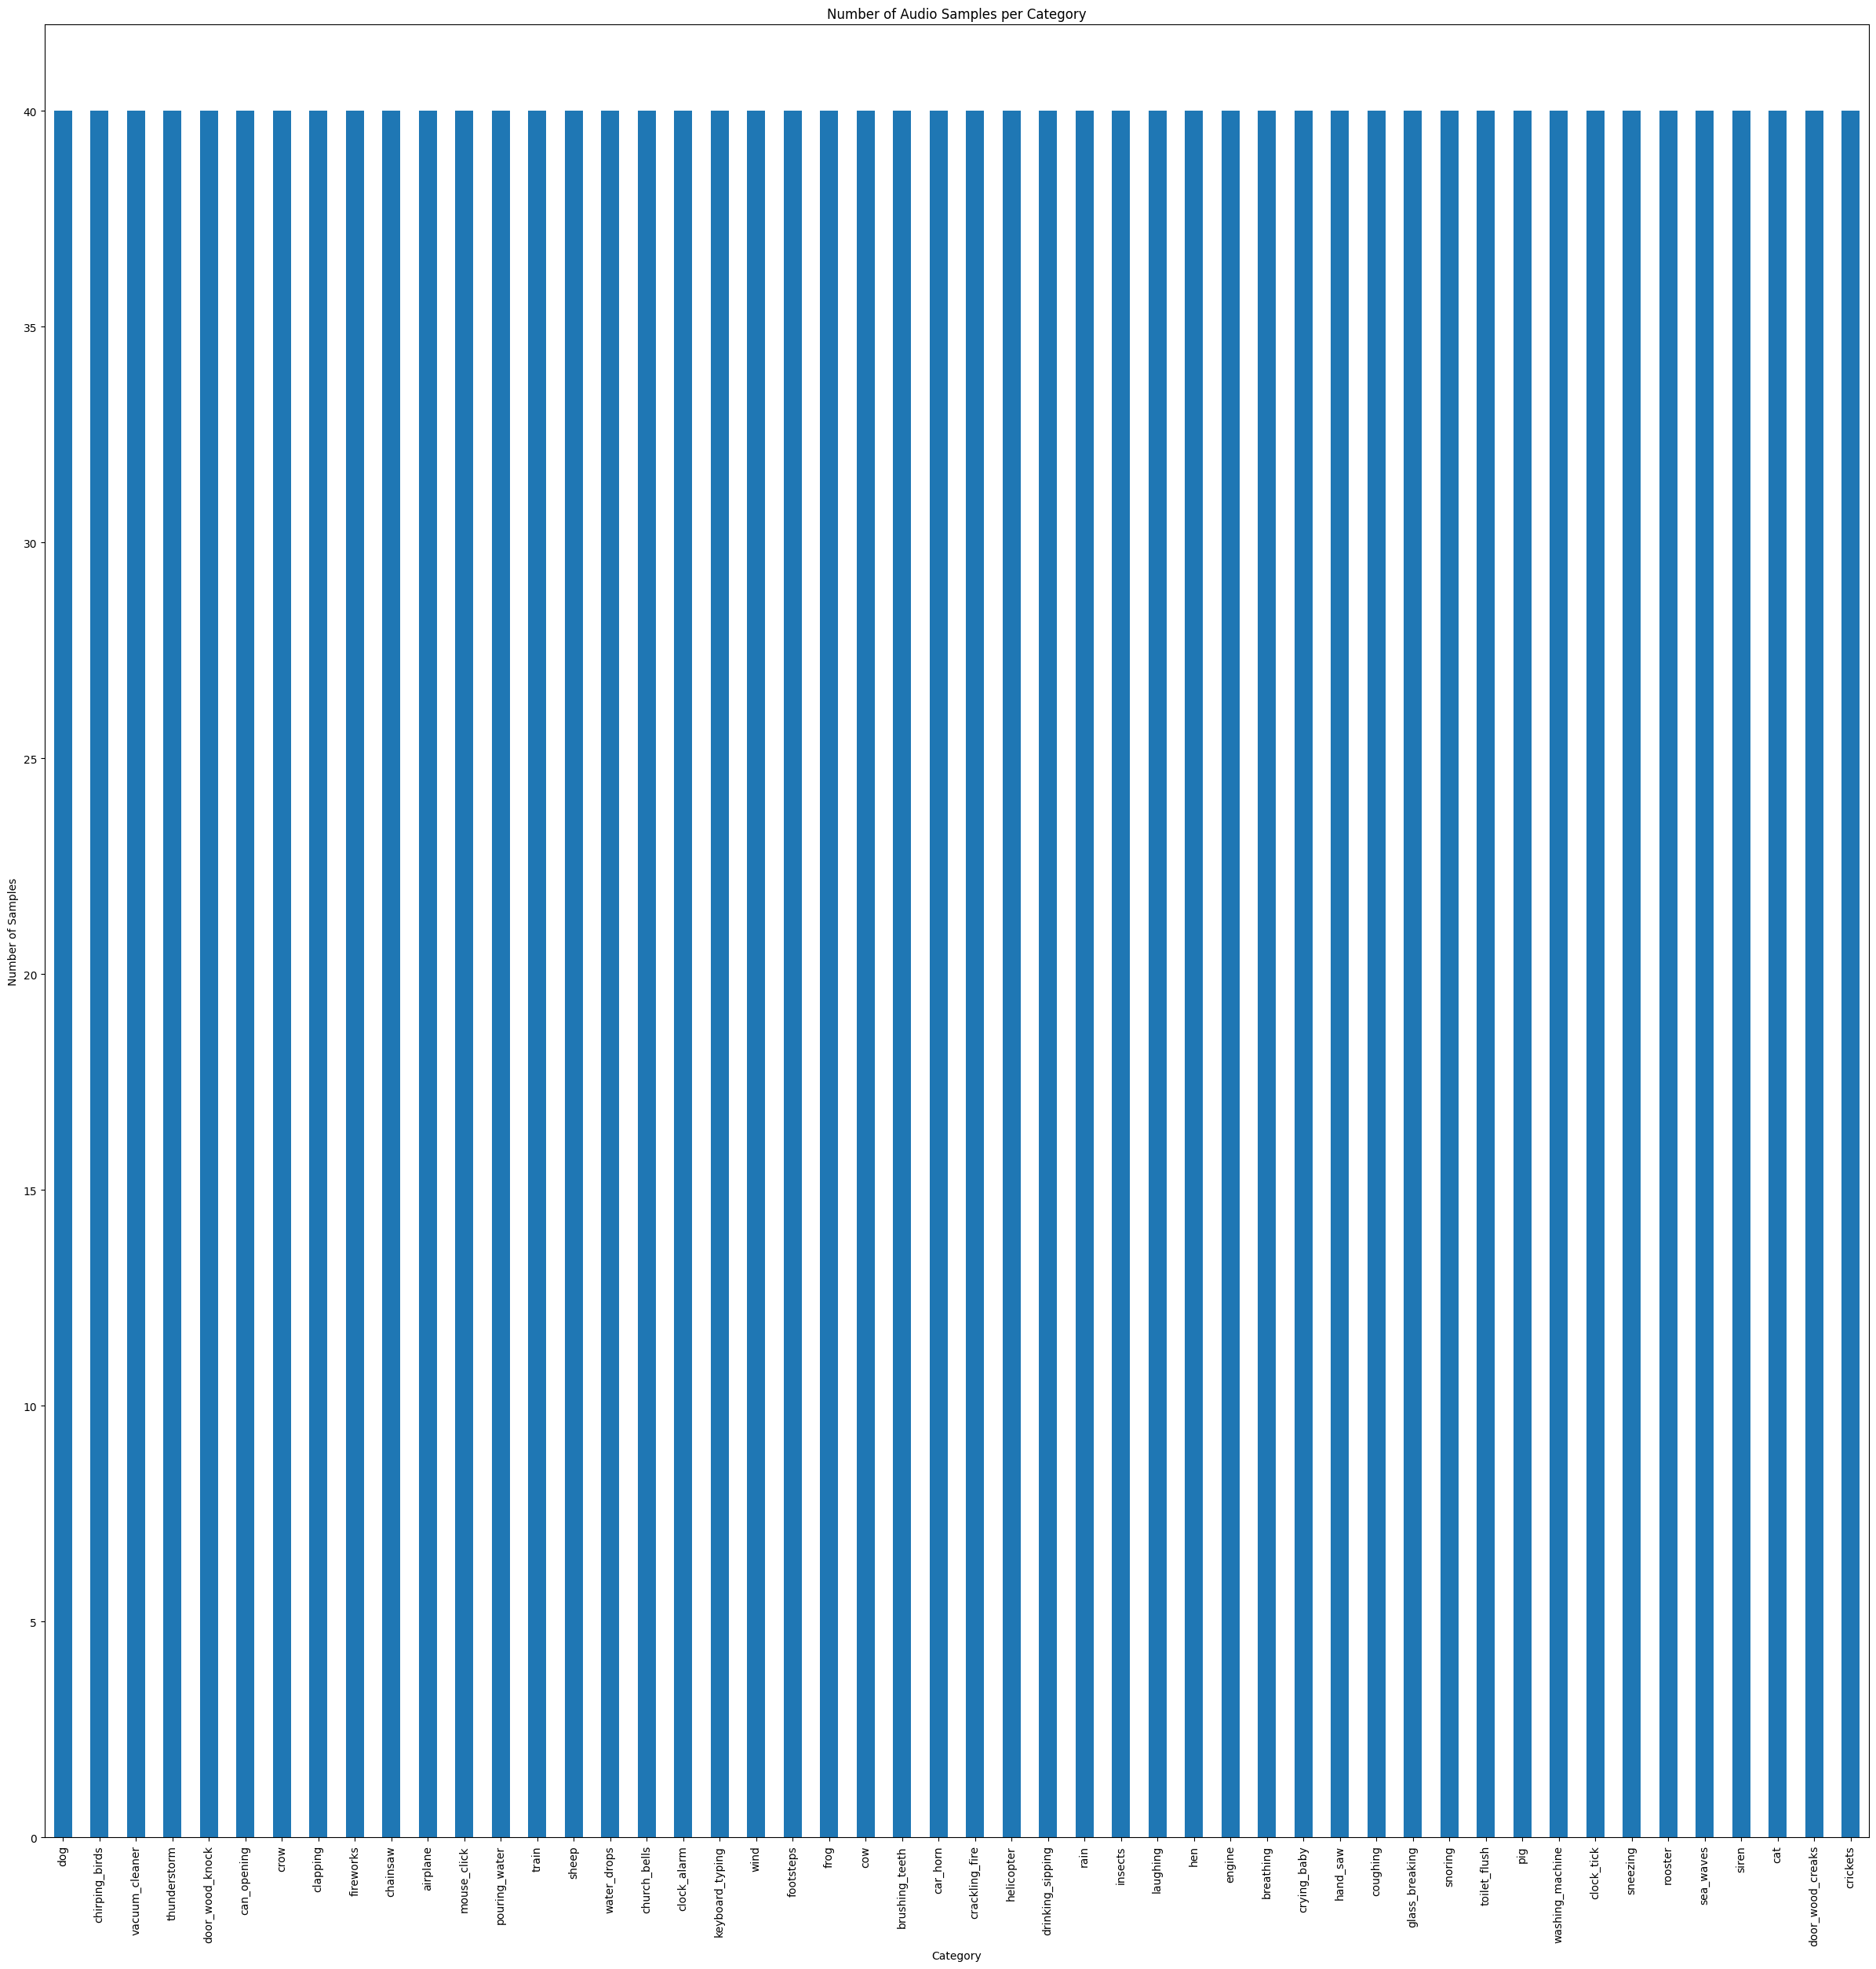

In [17]:
category_group = dataset['category'].value_counts()
plot = category_group.plot(kind='bar', title="Number of Audio Samples per Category", figsize=(30,30))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");

In [18]:
# get all sound files 
all_files = []
for path, subdirs, files in os.walk(DATA_PATH):
    for name in files:
        all_files.append(os.path.join(path, name))

In [19]:
plot_files = random.choices(all_files, k = 10)
plot_audios = [librosa.load(plot_files[i]) for i in range(10)]

## **Visualize Data**

In [21]:
decoder = {
    0: "dog",
    14: "chirping_birds",
    36: "vacuum_cleaner",
    19: "thunderstorm",
    30: "door_wood_knock",
    34: "can_opening",
    9: "crow",
    22: "clapping",
    48: "fireworks",
    41: "chainsaw",
    47: "airplane",
    31: "mouse_click",
    17: "pouring_water",
    45: "train",
    8: "sheep",
    15: "water_drops",
    46: "church_bells",
    37: "clock_alarm",
    32: "keyboard_typing",
    16: "wind",
    25: "footsteps",
    4: "frog",
    3: "cow",
    27: "brushing_teeth",
    43: "car_horn",
    12: "crackling_fire",
    40: "helicopter",
    29: "drinking_sipping",
    10: "rain",
    7: "insects",
    26: "laughing",
    6: "hen",
    44: "engine",
    23: "breathing",
    20: "crying_baby",
    49: "hand_saw",
    24: "coughing",
    39: "glass_breaking",
    28: "snoring",
    18: "toilet_flush",
    2: "pig",
    35: "washing_machine",
    38: "clock_tick",
    21: "sneezing",
    1: "rooster",
    11: "sea_waves",
    42: "siren",
    5: "cat",
    33: "door_wood_creaks",
    13: "crickets",
}

encoder = {v: k for k, v in decoder.items()} 

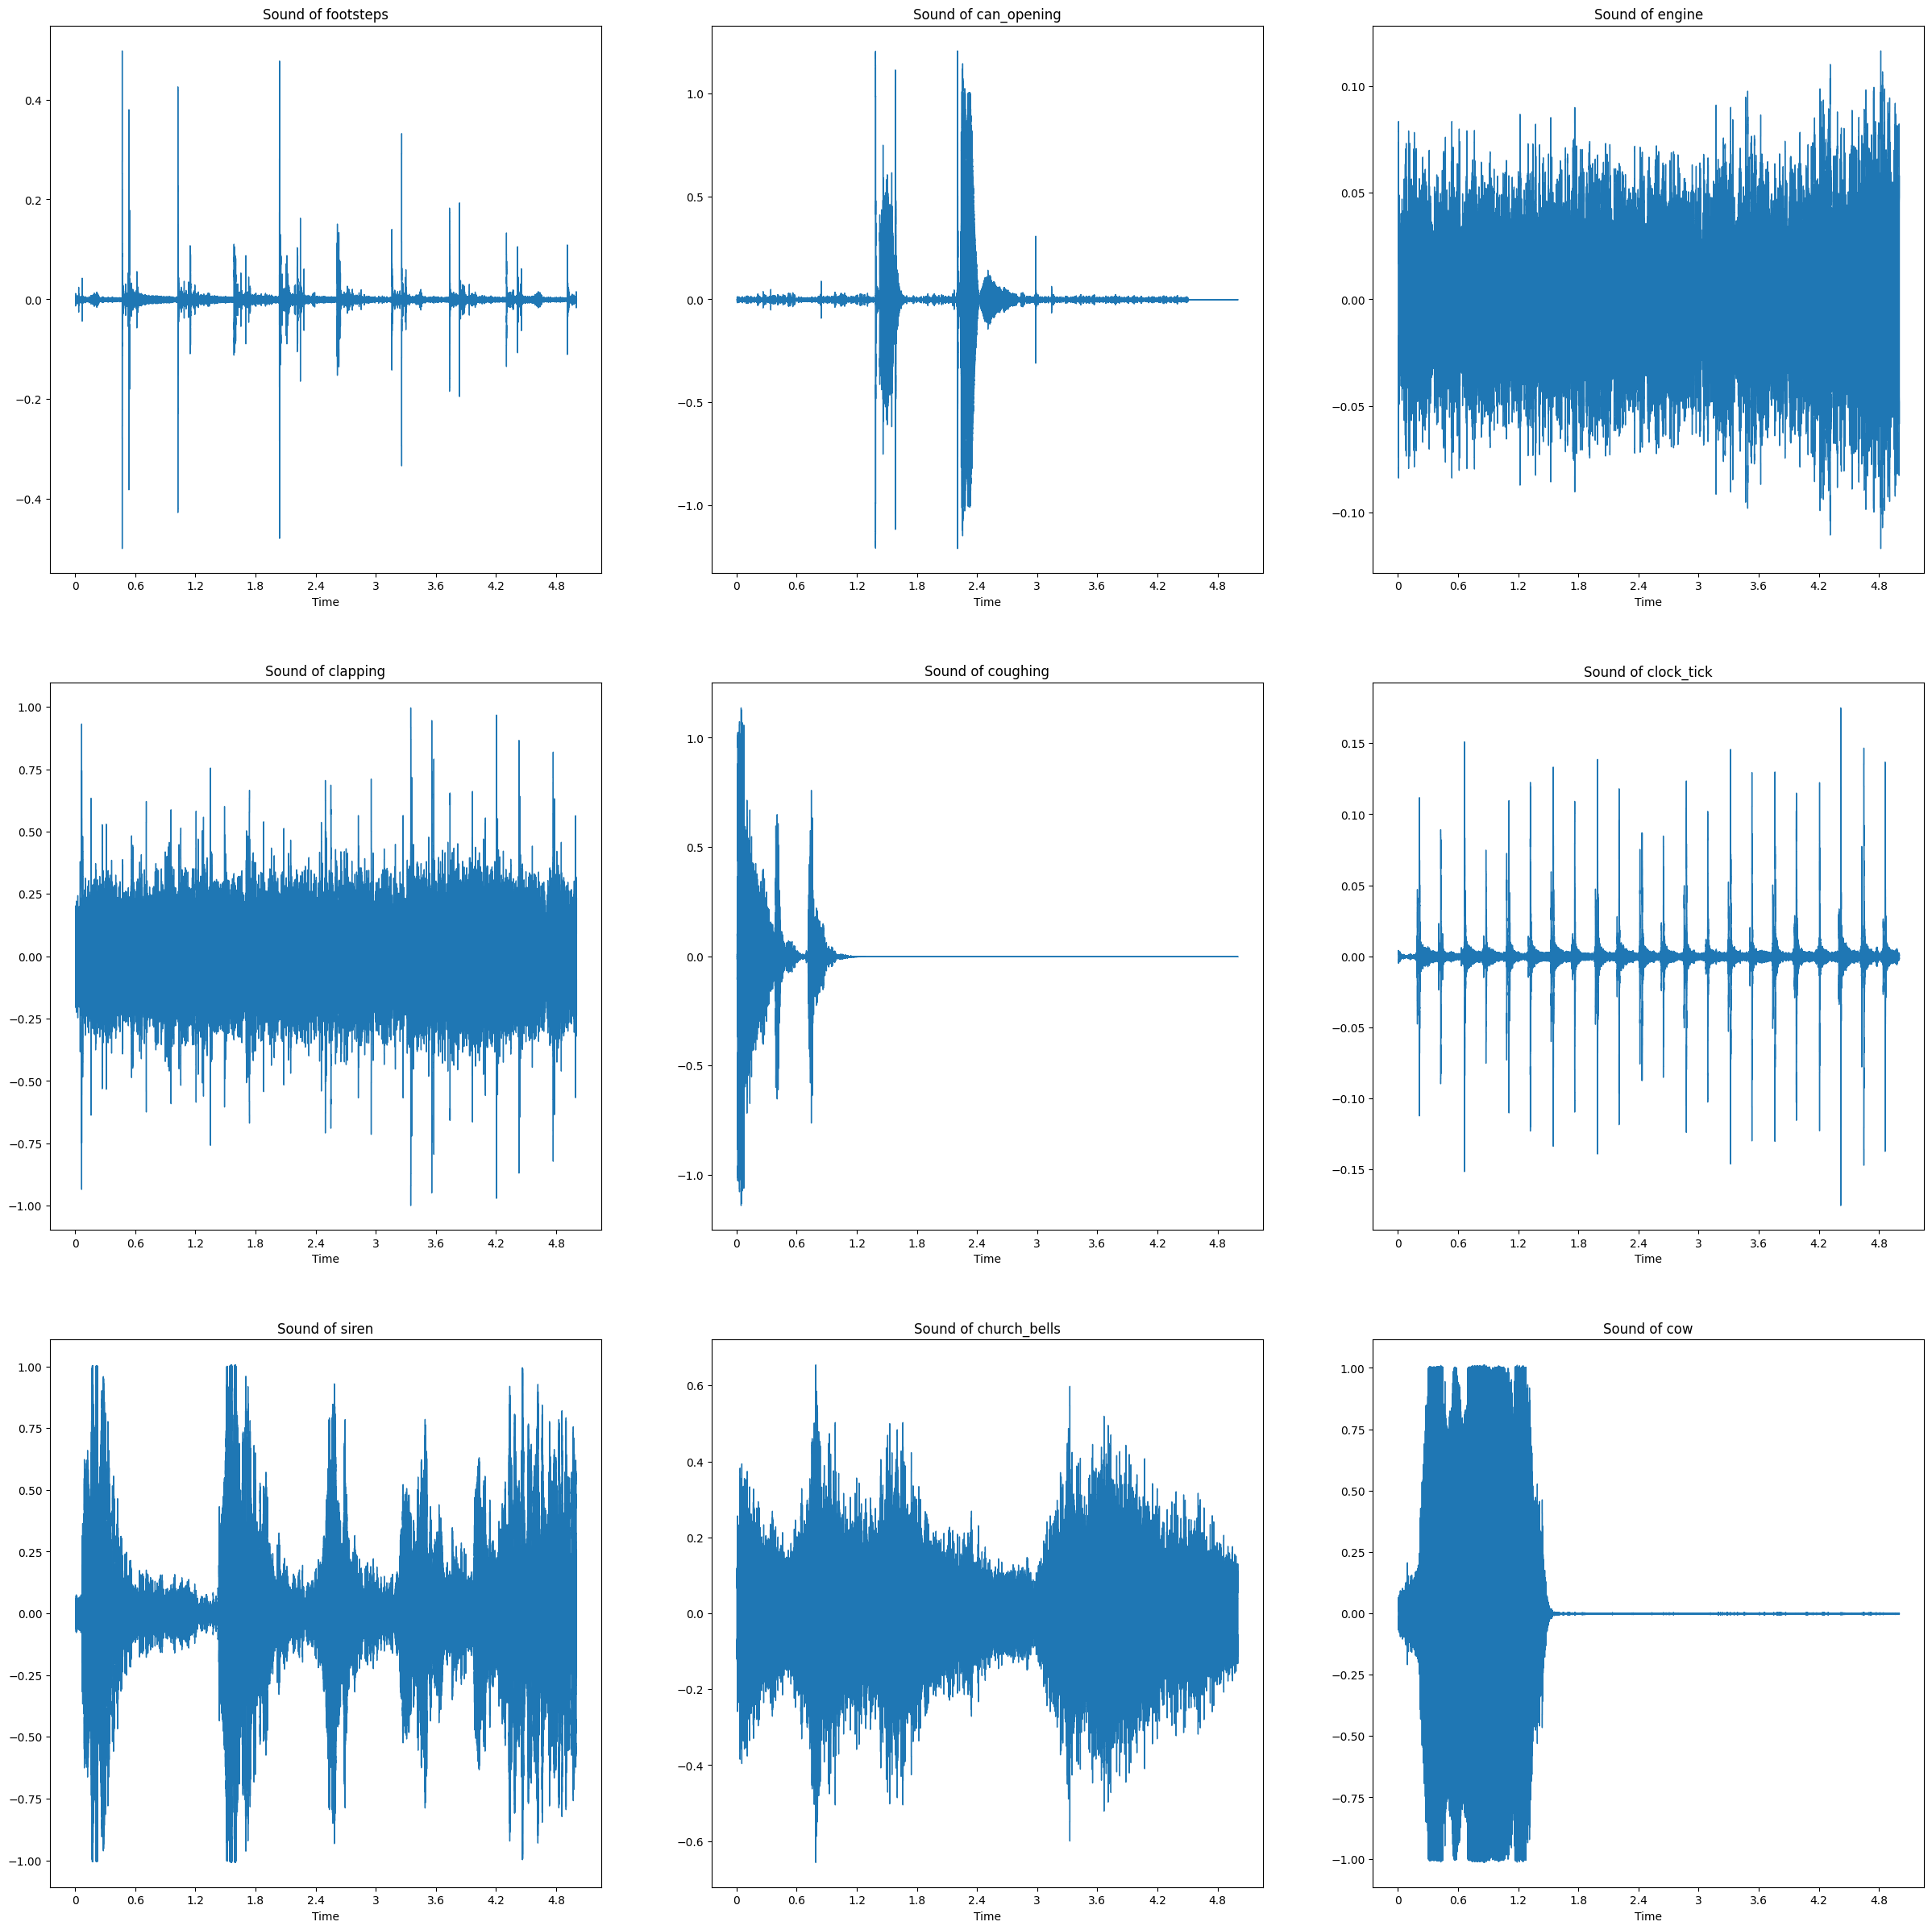

In [22]:
plt.figure(figsize=(30,30))
for i in range(1,10):
    plt.subplot(3,3,i)
    librosa.display.waveshow(plot_audios[i][0])
    try:
        plt.title("Sound of " + decoder[int(plot_files[i][-6:-4])] )
    except:
        plt.title("Sound of " + decoder[int(plot_files[i][-5:-4])] )

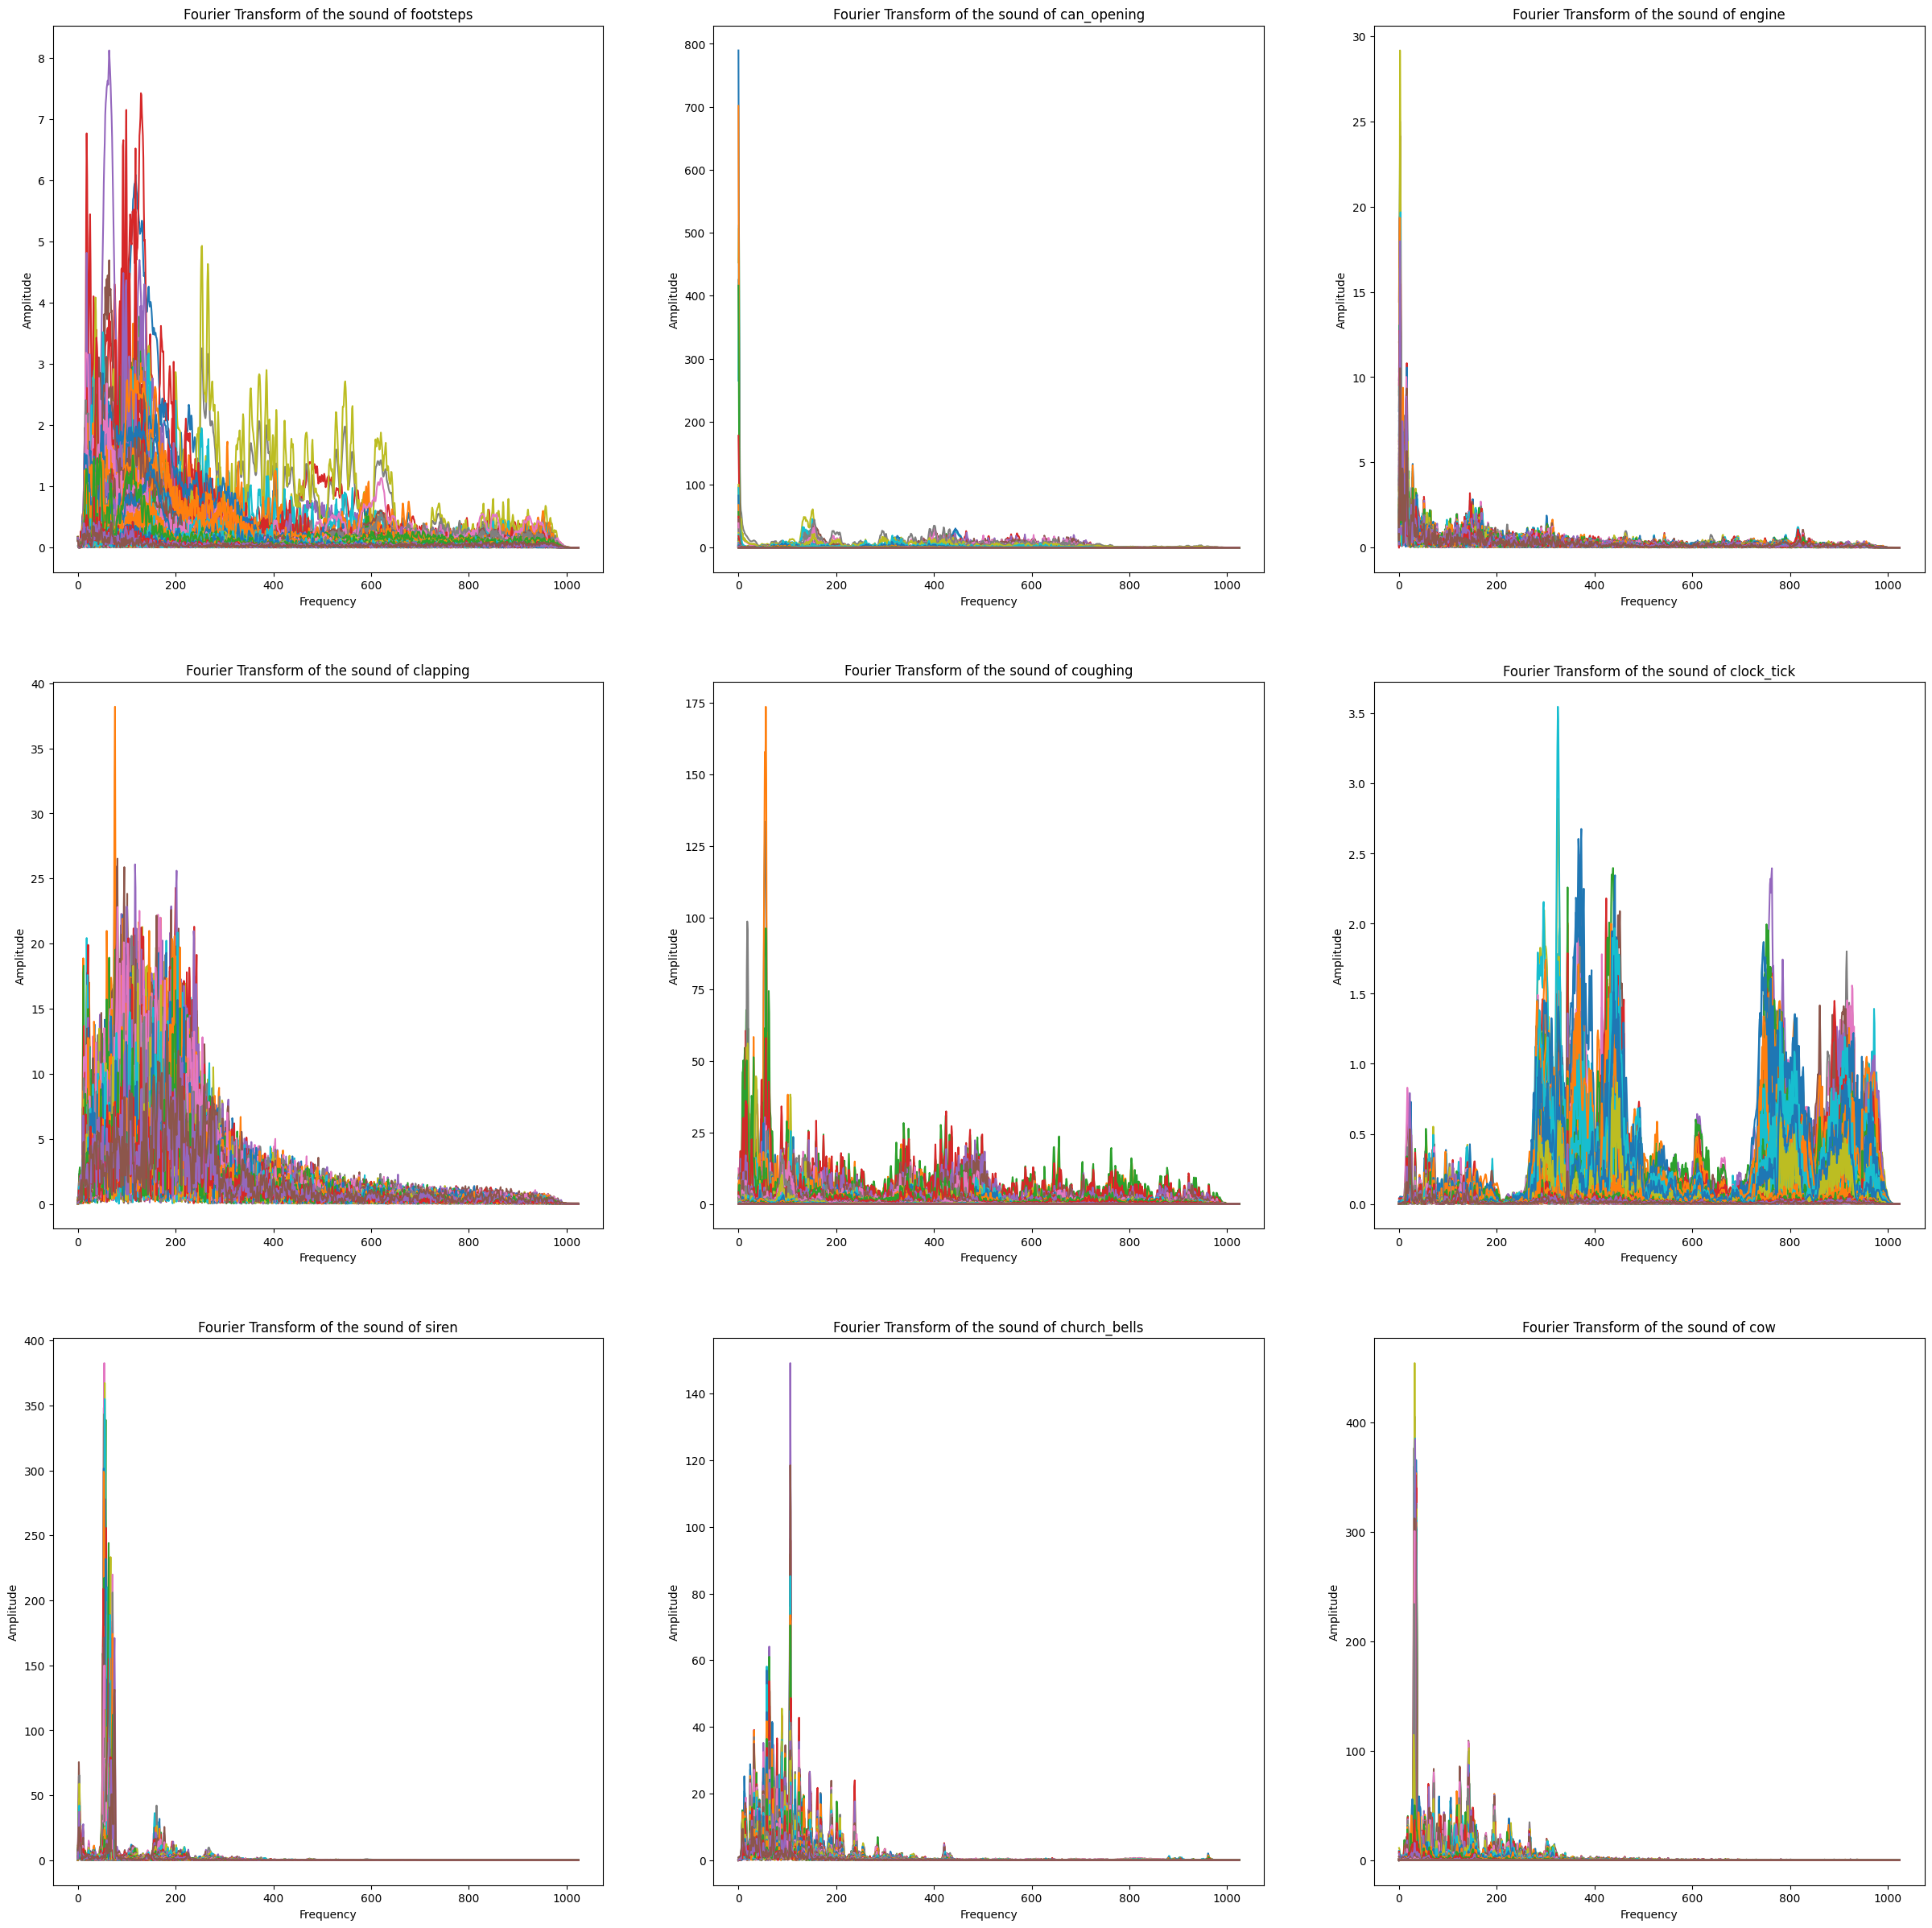

In [23]:
# default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns 

plt.figure(figsize=(30,30))
for i in range(1,10):
    plt.subplot(3,3,i)
    X = np.abs(librosa.stft(plot_audios[i][0], n_fft = n_fft, hop_length = hop_length))
    plt.plot(X)
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude");
    try:
        plt.title("Fourier Transform of the sound of " + decoder[int(plot_files[i][-6:-4])] )
    except:
        plt.title("Fourier Transform of the sound of " + decoder[int(plot_files[i][-5:-4])] )


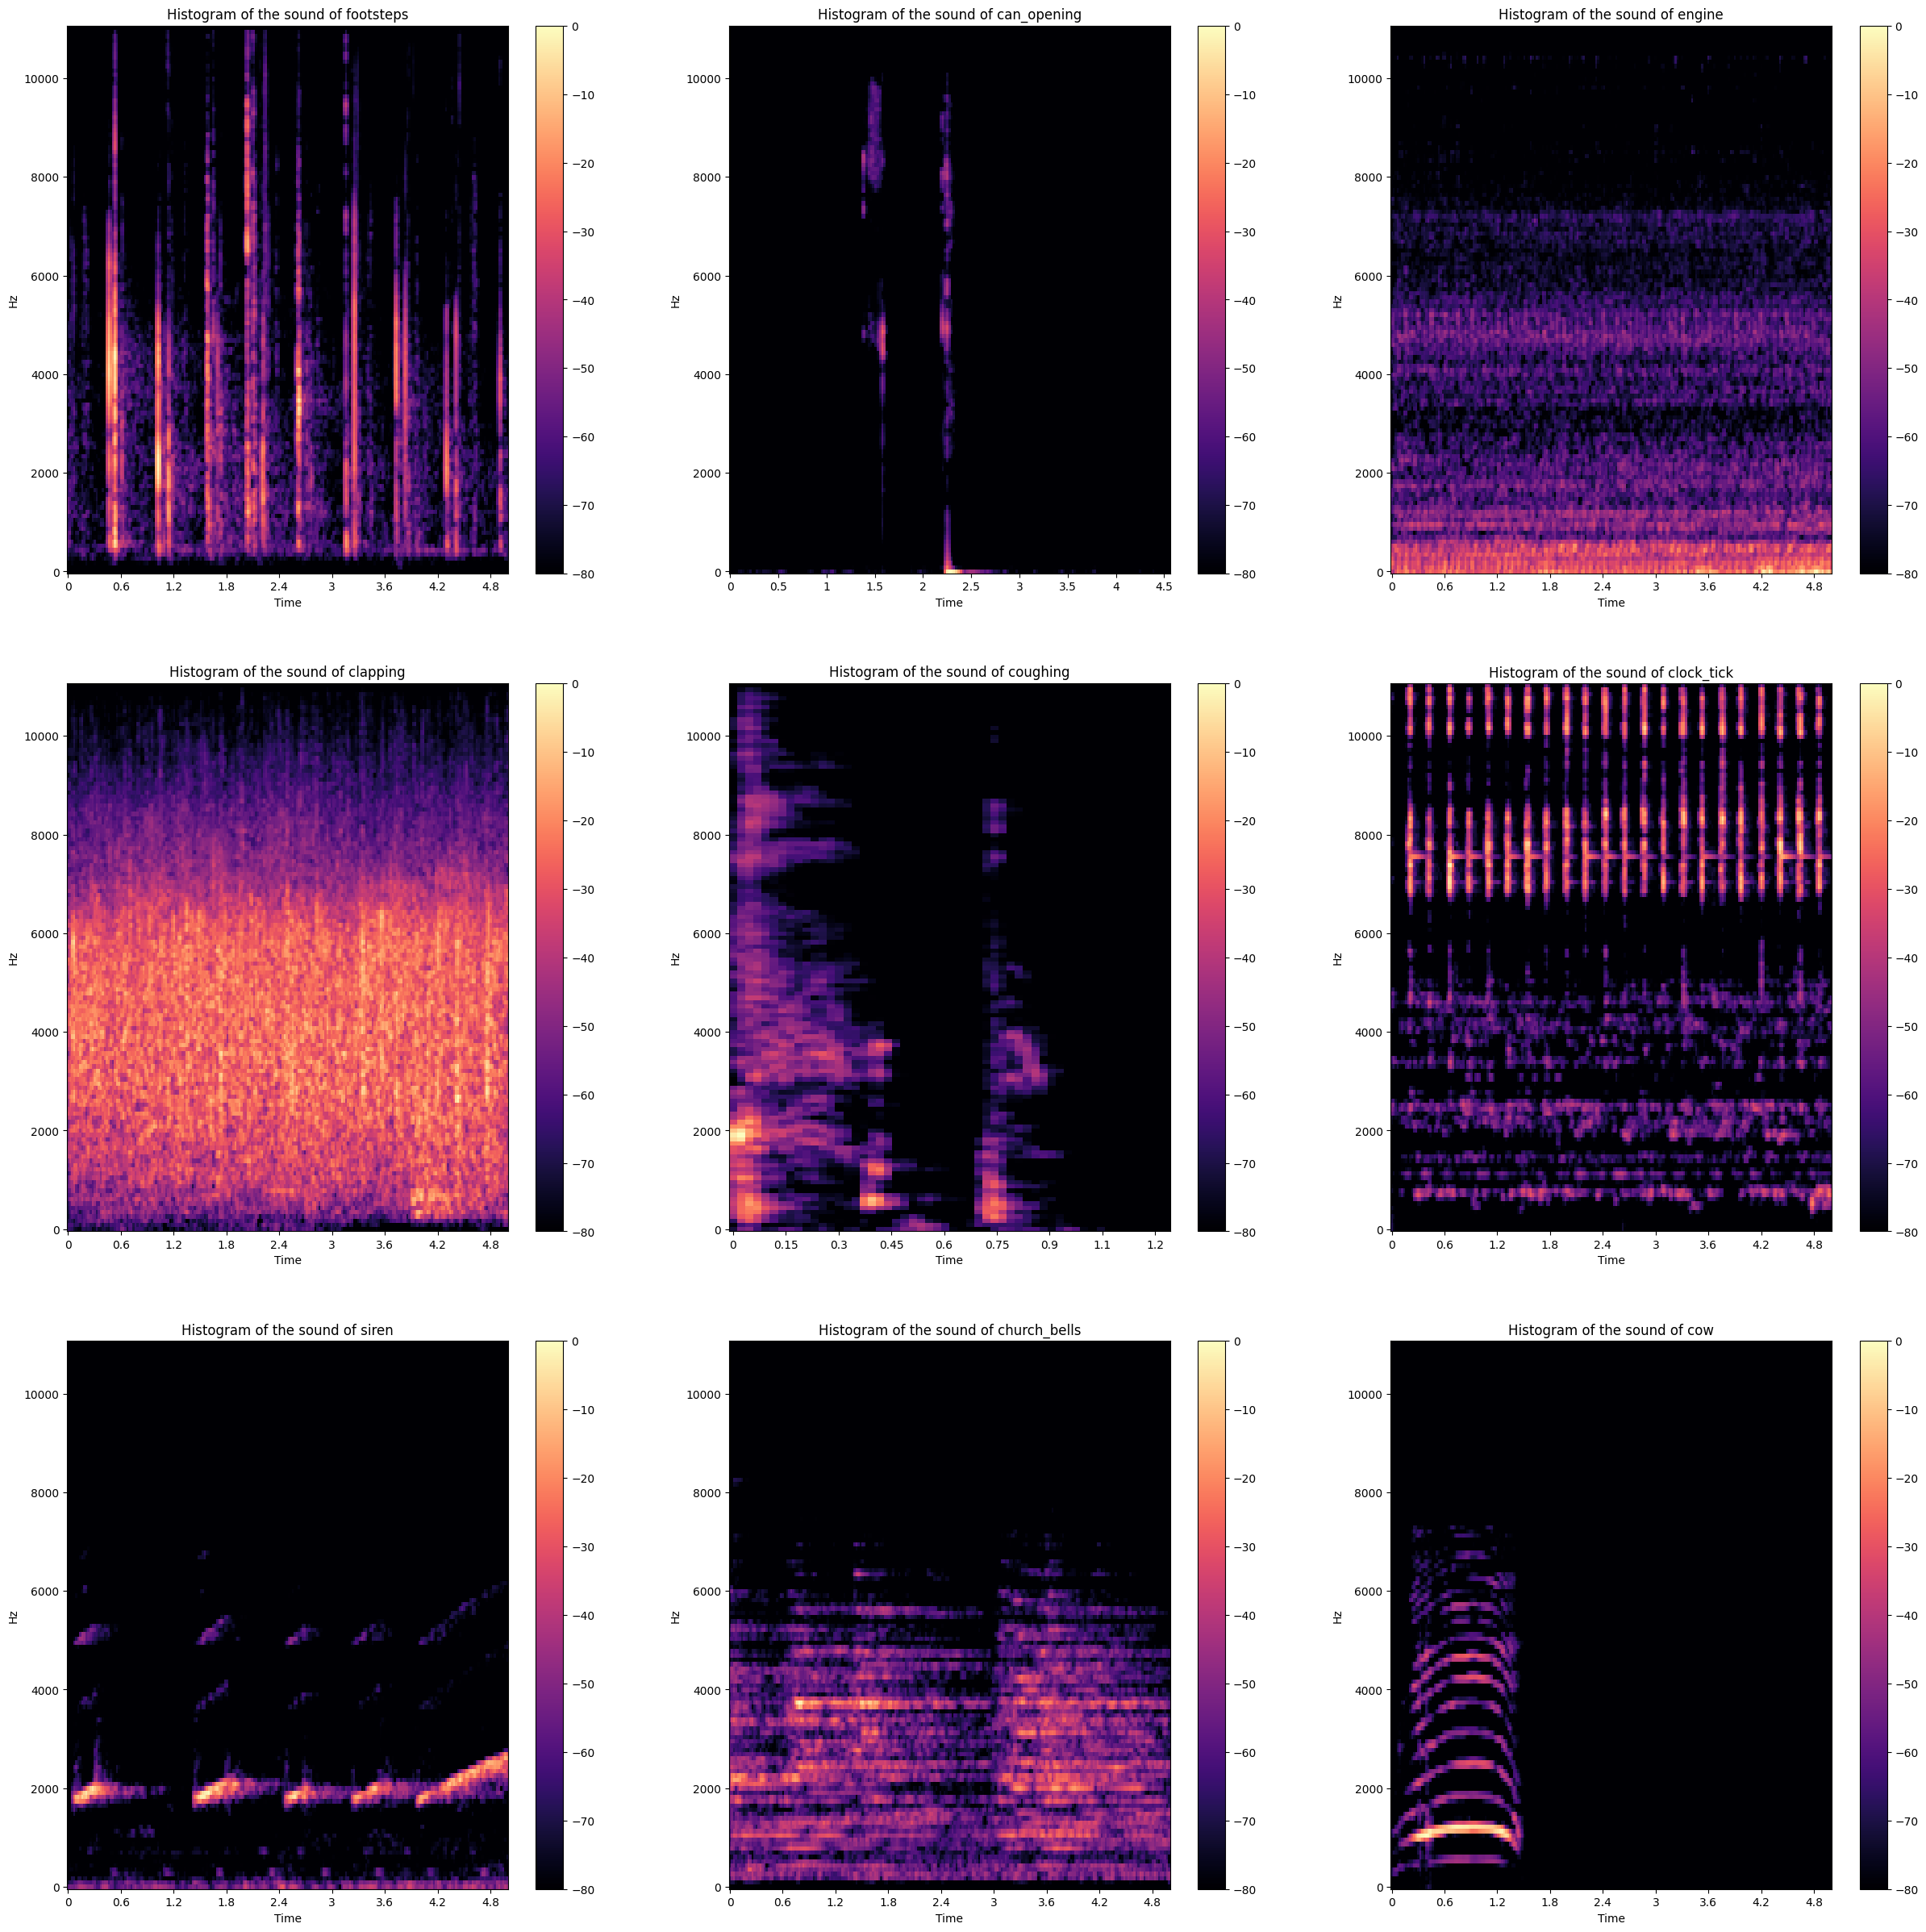

In [24]:
# mel-spectrogram representation 
plt.figure(figsize=(30,30))
for i in range(1,10):
    plt.subplot(3,3,i)
    X, _ = librosa.effects.trim(plot_audios[i][0])
    XS = librosa.feature.melspectrogram(y=X, sr=plot_audios[i][1])
    Xdb = librosa.amplitude_to_db(XS, ref=np.max)
    librosa.display.specshow(Xdb, sr=plot_audios[i][1], x_axis='time', y_axis='hz')
    plt.colorbar()
    try:
        plt.title("Histogram of the sound of " + decoder[int(plot_files[i][-6:-4])] )
    except:
        plt.title("Histogram of the sound of " + decoder[int(plot_files[i][-5:-4])] )

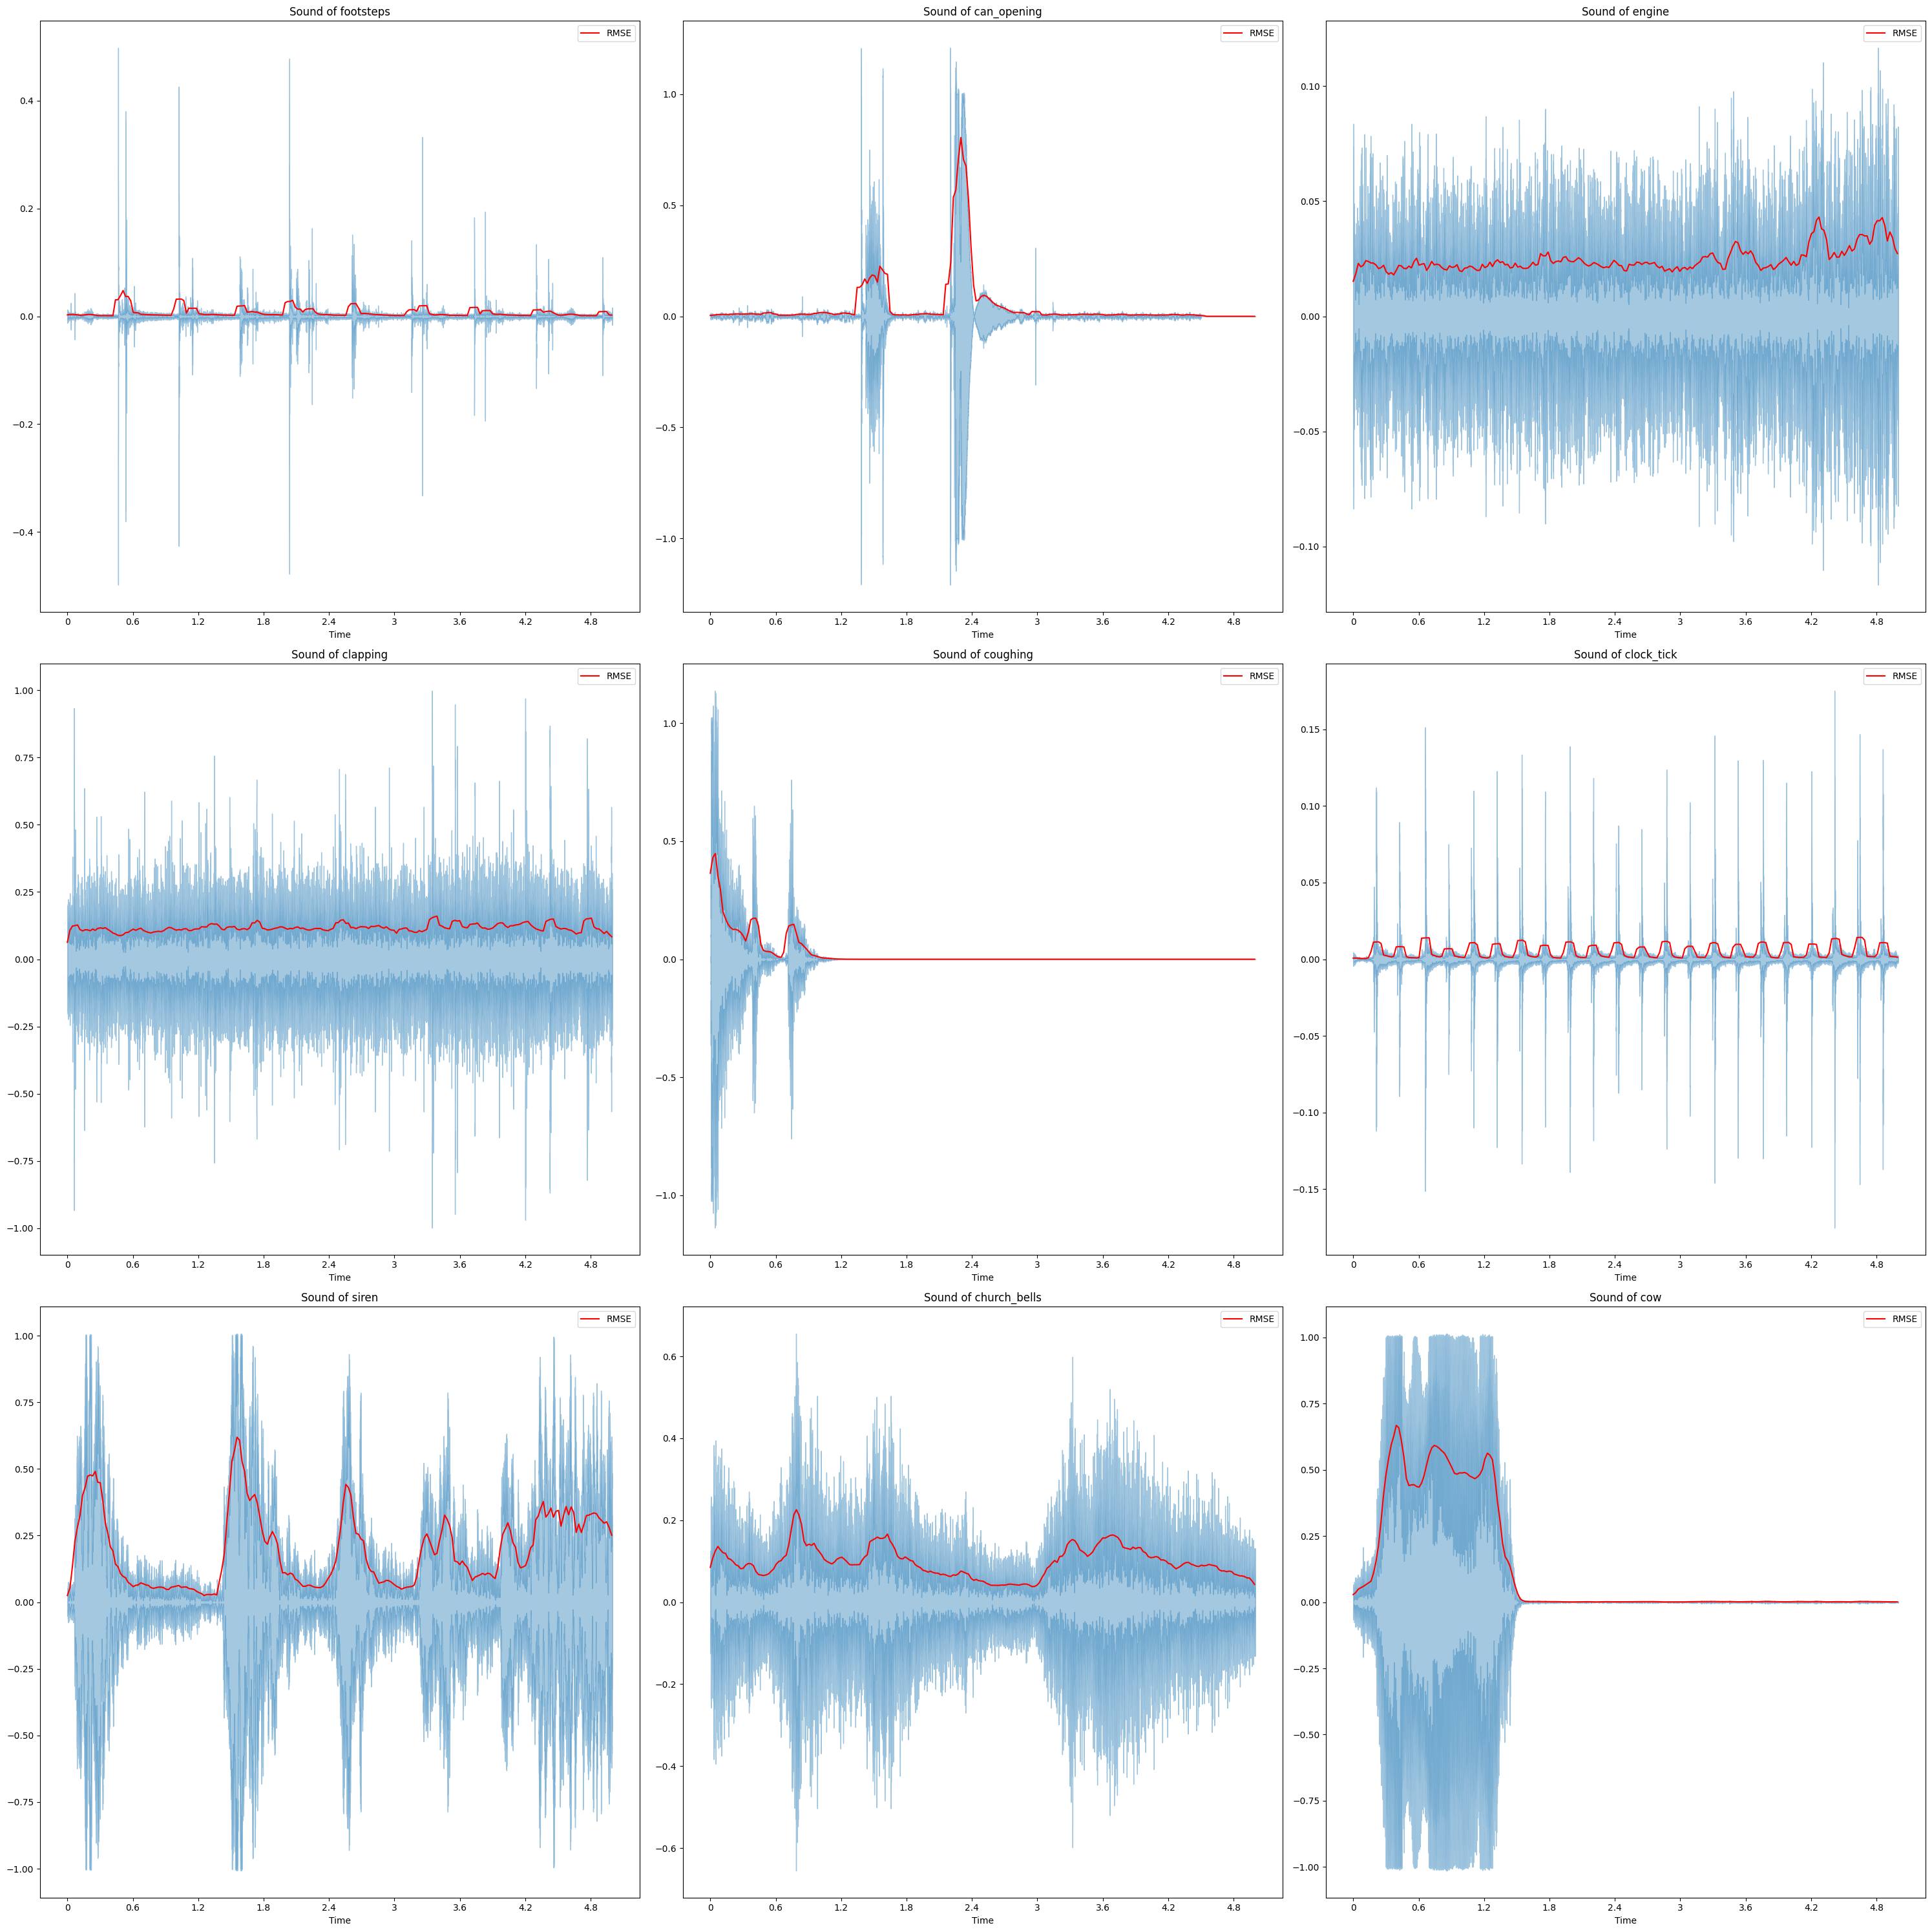

In [25]:
# visualize waveform
plt.figure(figsize=(30, 30))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    y = plot_audios[i][0]
    sr = plot_audios[i][1]

    # calculate RMSE 
    rmse = librosa.feature.rms(y=y)[0]

    # time axis 
    frames = range(len(rmse))
    t = librosa.frames_to_time(frames, sr=sr)

    # display waveform 
    librosa.display.waveshow(y, sr=sr, alpha=0.4)
    plt.plot(t, rmse, color='r', label="RMSE")

    try:
        plt.title("Sound of " + decoder[int(plot_files[i][-6:-4])])
    except:
        plt.title("Sound of " + decoder[int(plot_files[i][-5:-4])])
    
    plt.legend()

plt.tight_layout()
plt.show()

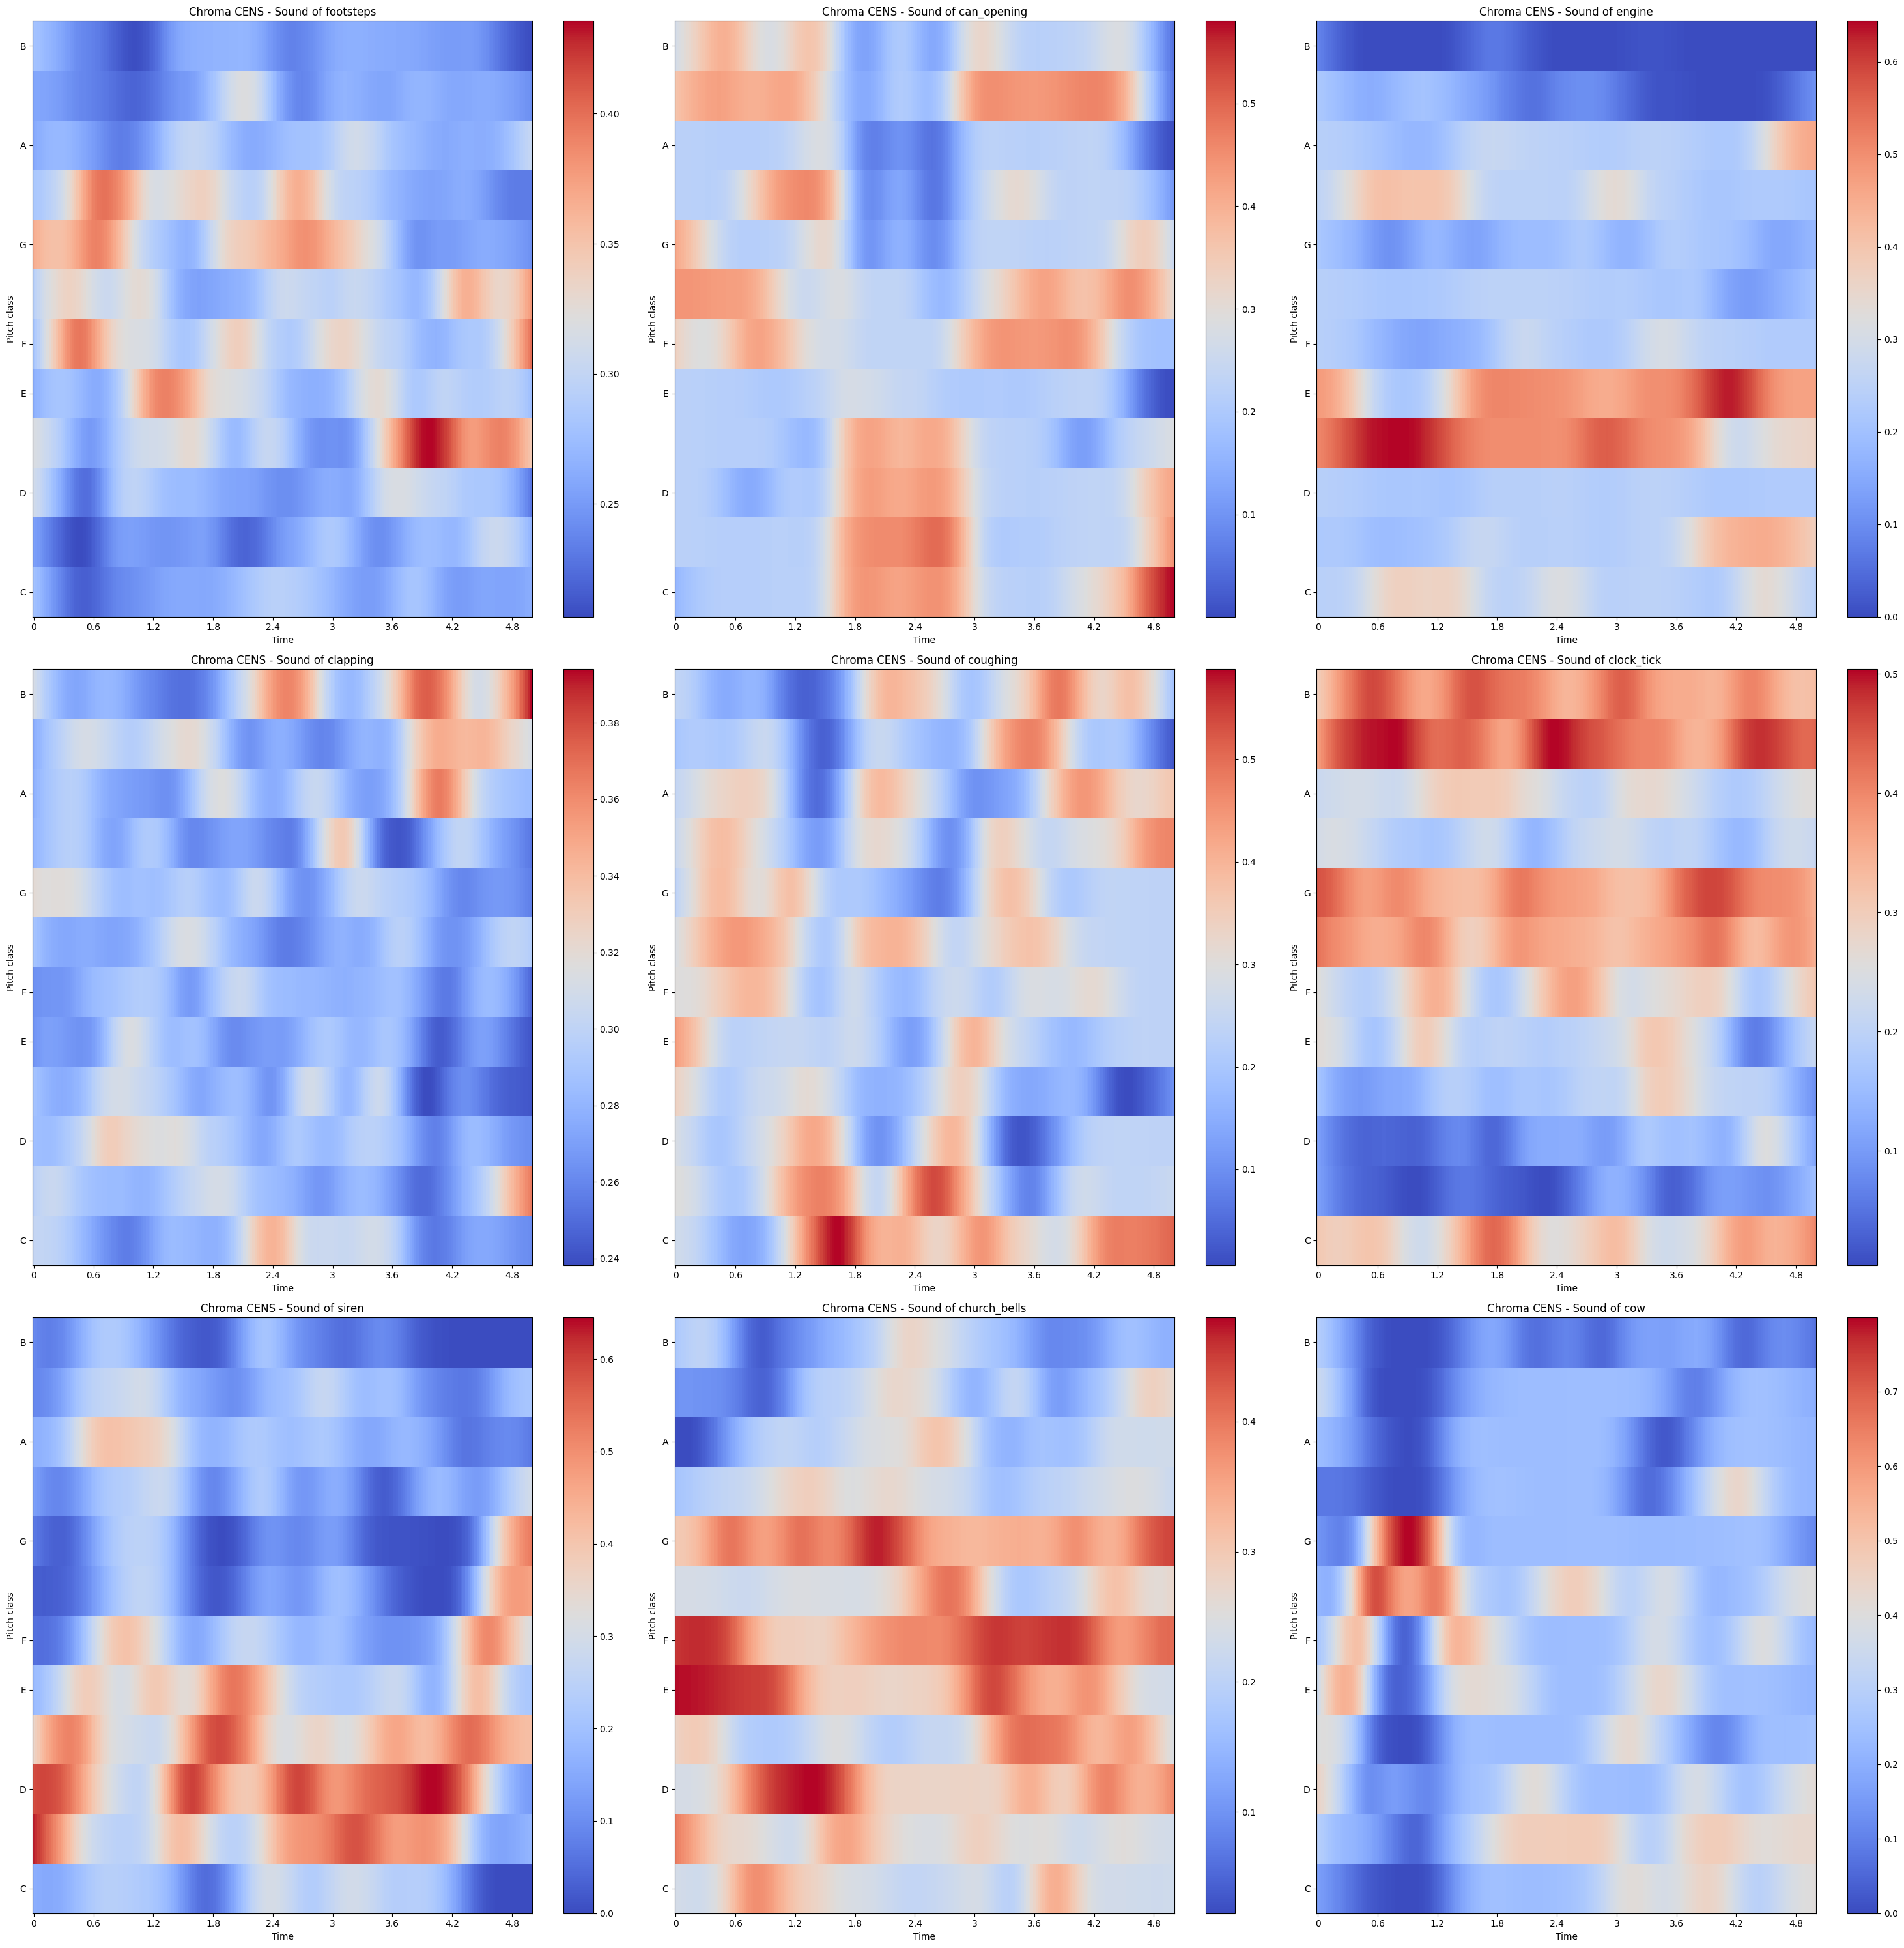

In [26]:
plt.figure(figsize=(30, 30))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    y = plot_audios[i][0]
    sr = plot_audios[i][1]

    # Tính toán chroma_cens
    chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr)

    # Hiển thị chroma_cens bằng specshow
    librosa.display.specshow(chroma_cens, sr=sr, x_axis='time', y_axis='chroma', cmap='coolwarm')

    try:
        plt.title("Chroma CENS - Sound of " + decoder[int(plot_files[i][-6:-4])])
    except:
        plt.title("Chroma CENS - Sound of " + decoder[int(plot_files[i][-5:-4])])

    plt.colorbar()

plt.tight_layout()
plt.show()

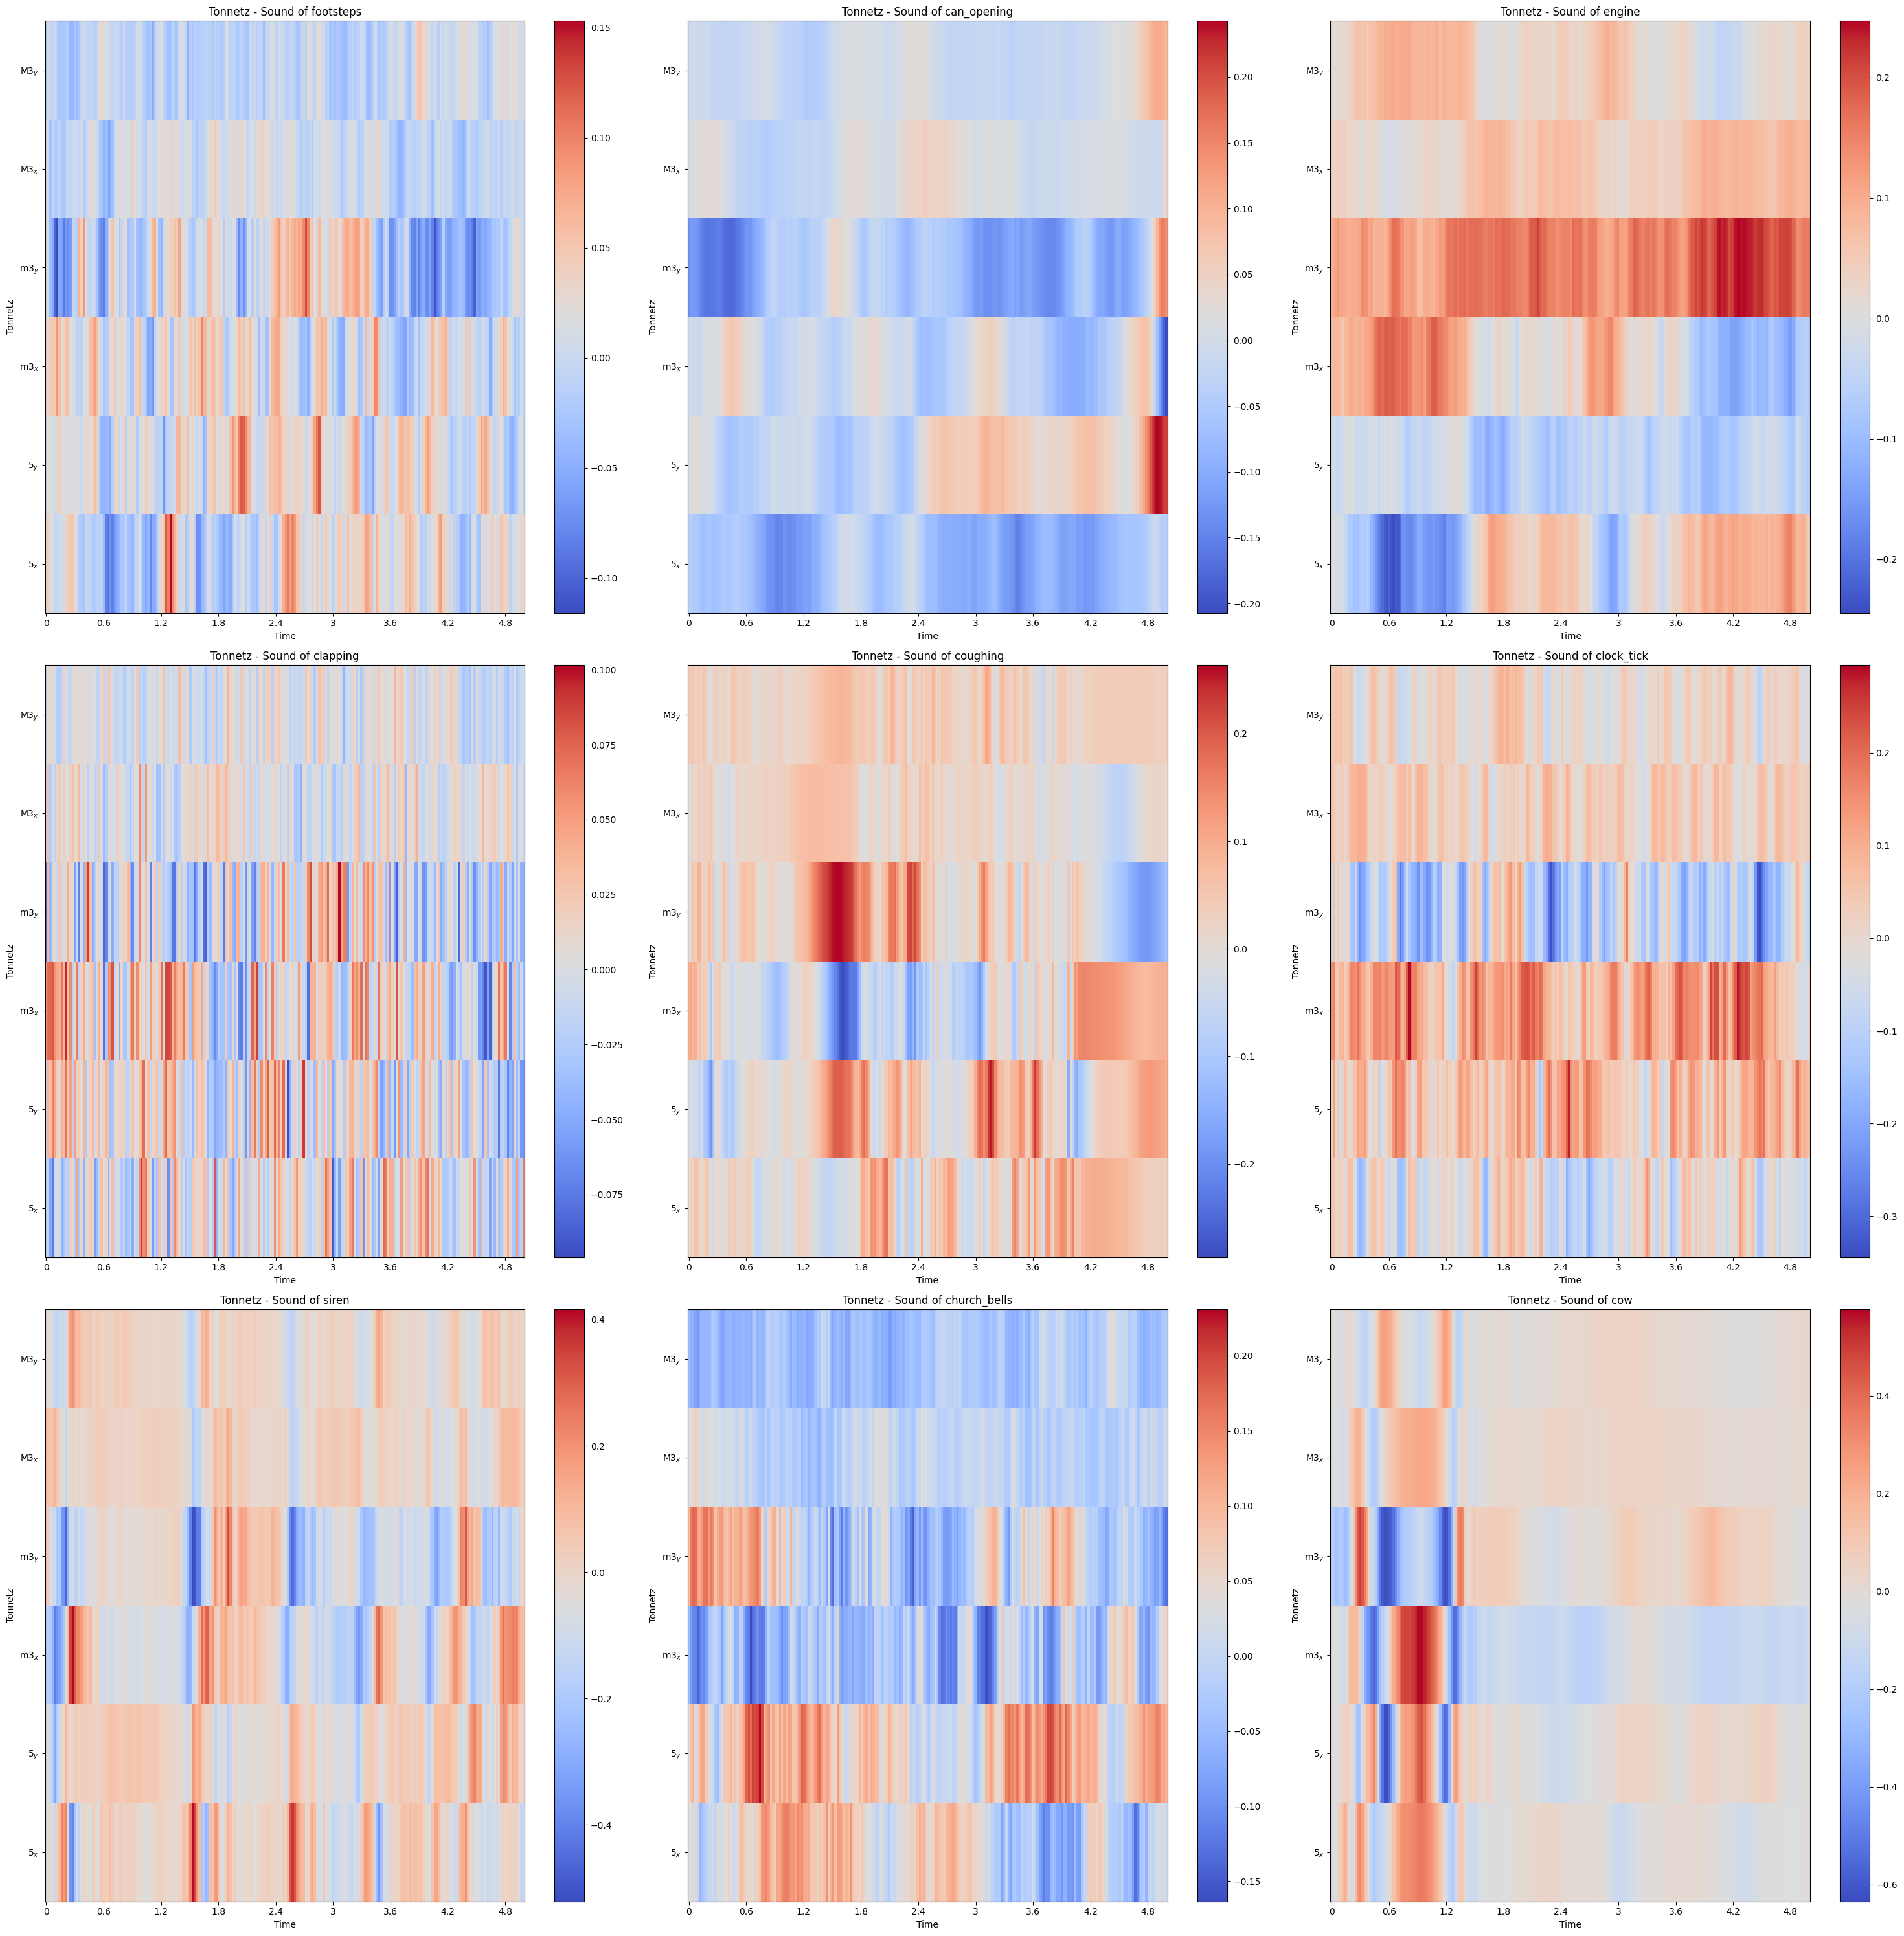

In [27]:
plt.figure(figsize=(30, 30))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    y = plot_audios[i][0]
    sr = plot_audios[i][1]

    # Tính toán tonnetz
    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)

    # Hiển thị tonnetz bằng specshow
    librosa.display.specshow(tonnetz, sr=sr, x_axis='time', y_axis='tonnetz', cmap='coolwarm')

    try:
        plt.title("Tonnetz - Sound of " + decoder[int(plot_files[i][-6:-4])])
    except:
        plt.title("Tonnetz - Sound of " + decoder[int(plot_files[i][-5:-4])])

    plt.colorbar()

plt.tight_layout()
plt.show()

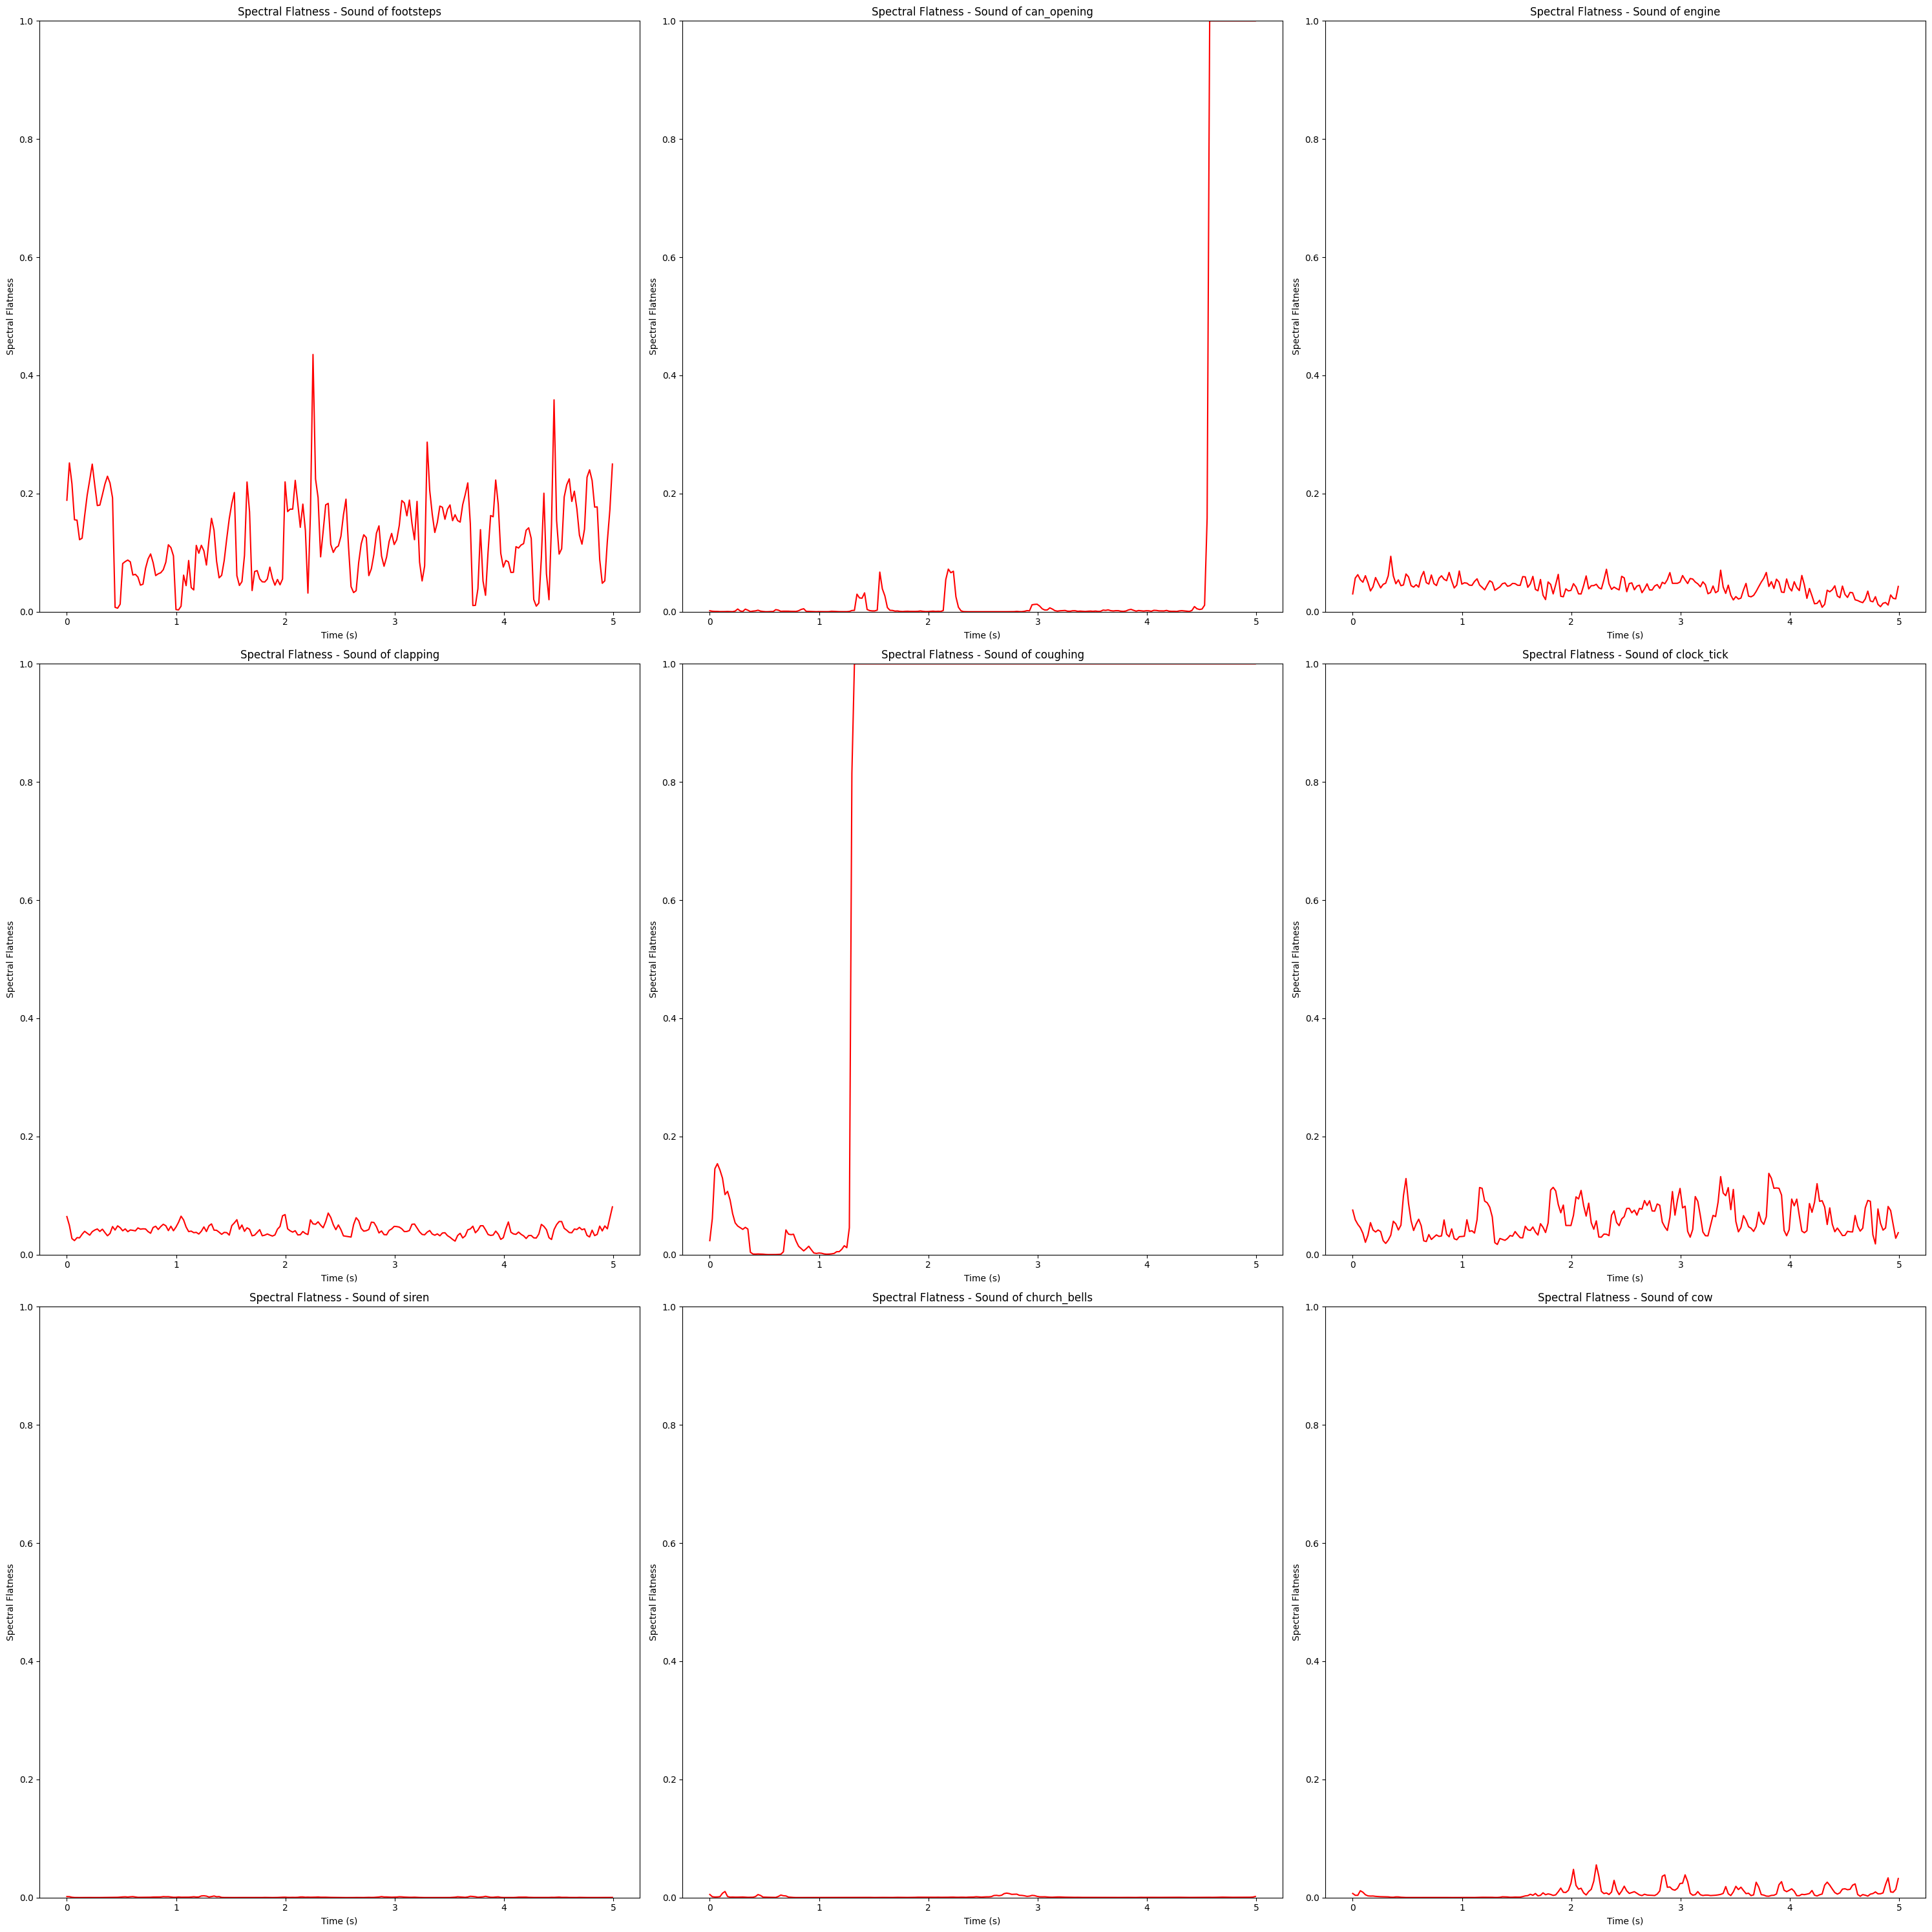

In [28]:
plt.figure(figsize=(30, 30))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    y = plot_audios[i][0]
    sr = plot_audios[i][1]

    # Tính toán Spectral Flatness
    spectral_flatness = librosa.feature.spectral_flatness(y=y)

    # Trục thời gian
    frames = range(len(spectral_flatness[0]))
    t = librosa.frames_to_time(frames, sr=sr)

    # Vẽ biểu đồ Spectral Flatness
    plt.plot(t, spectral_flatness[0], color='r')
    plt.xlabel("Time (s)")
    plt.ylabel("Spectral Flatness")
    plt.ylim(0, 1)  # Giá trị Spectral Flatness nằm trong khoảng 0-1

    try:
        plt.title("Spectral Flatness - Sound of " + decoder[int(plot_files[i][-6:-4])])
    except:
        plt.title("Spectral Flatness - Sound of " + decoder[int(plot_files[i][-5:-4])])

plt.tight_layout()
plt.show()


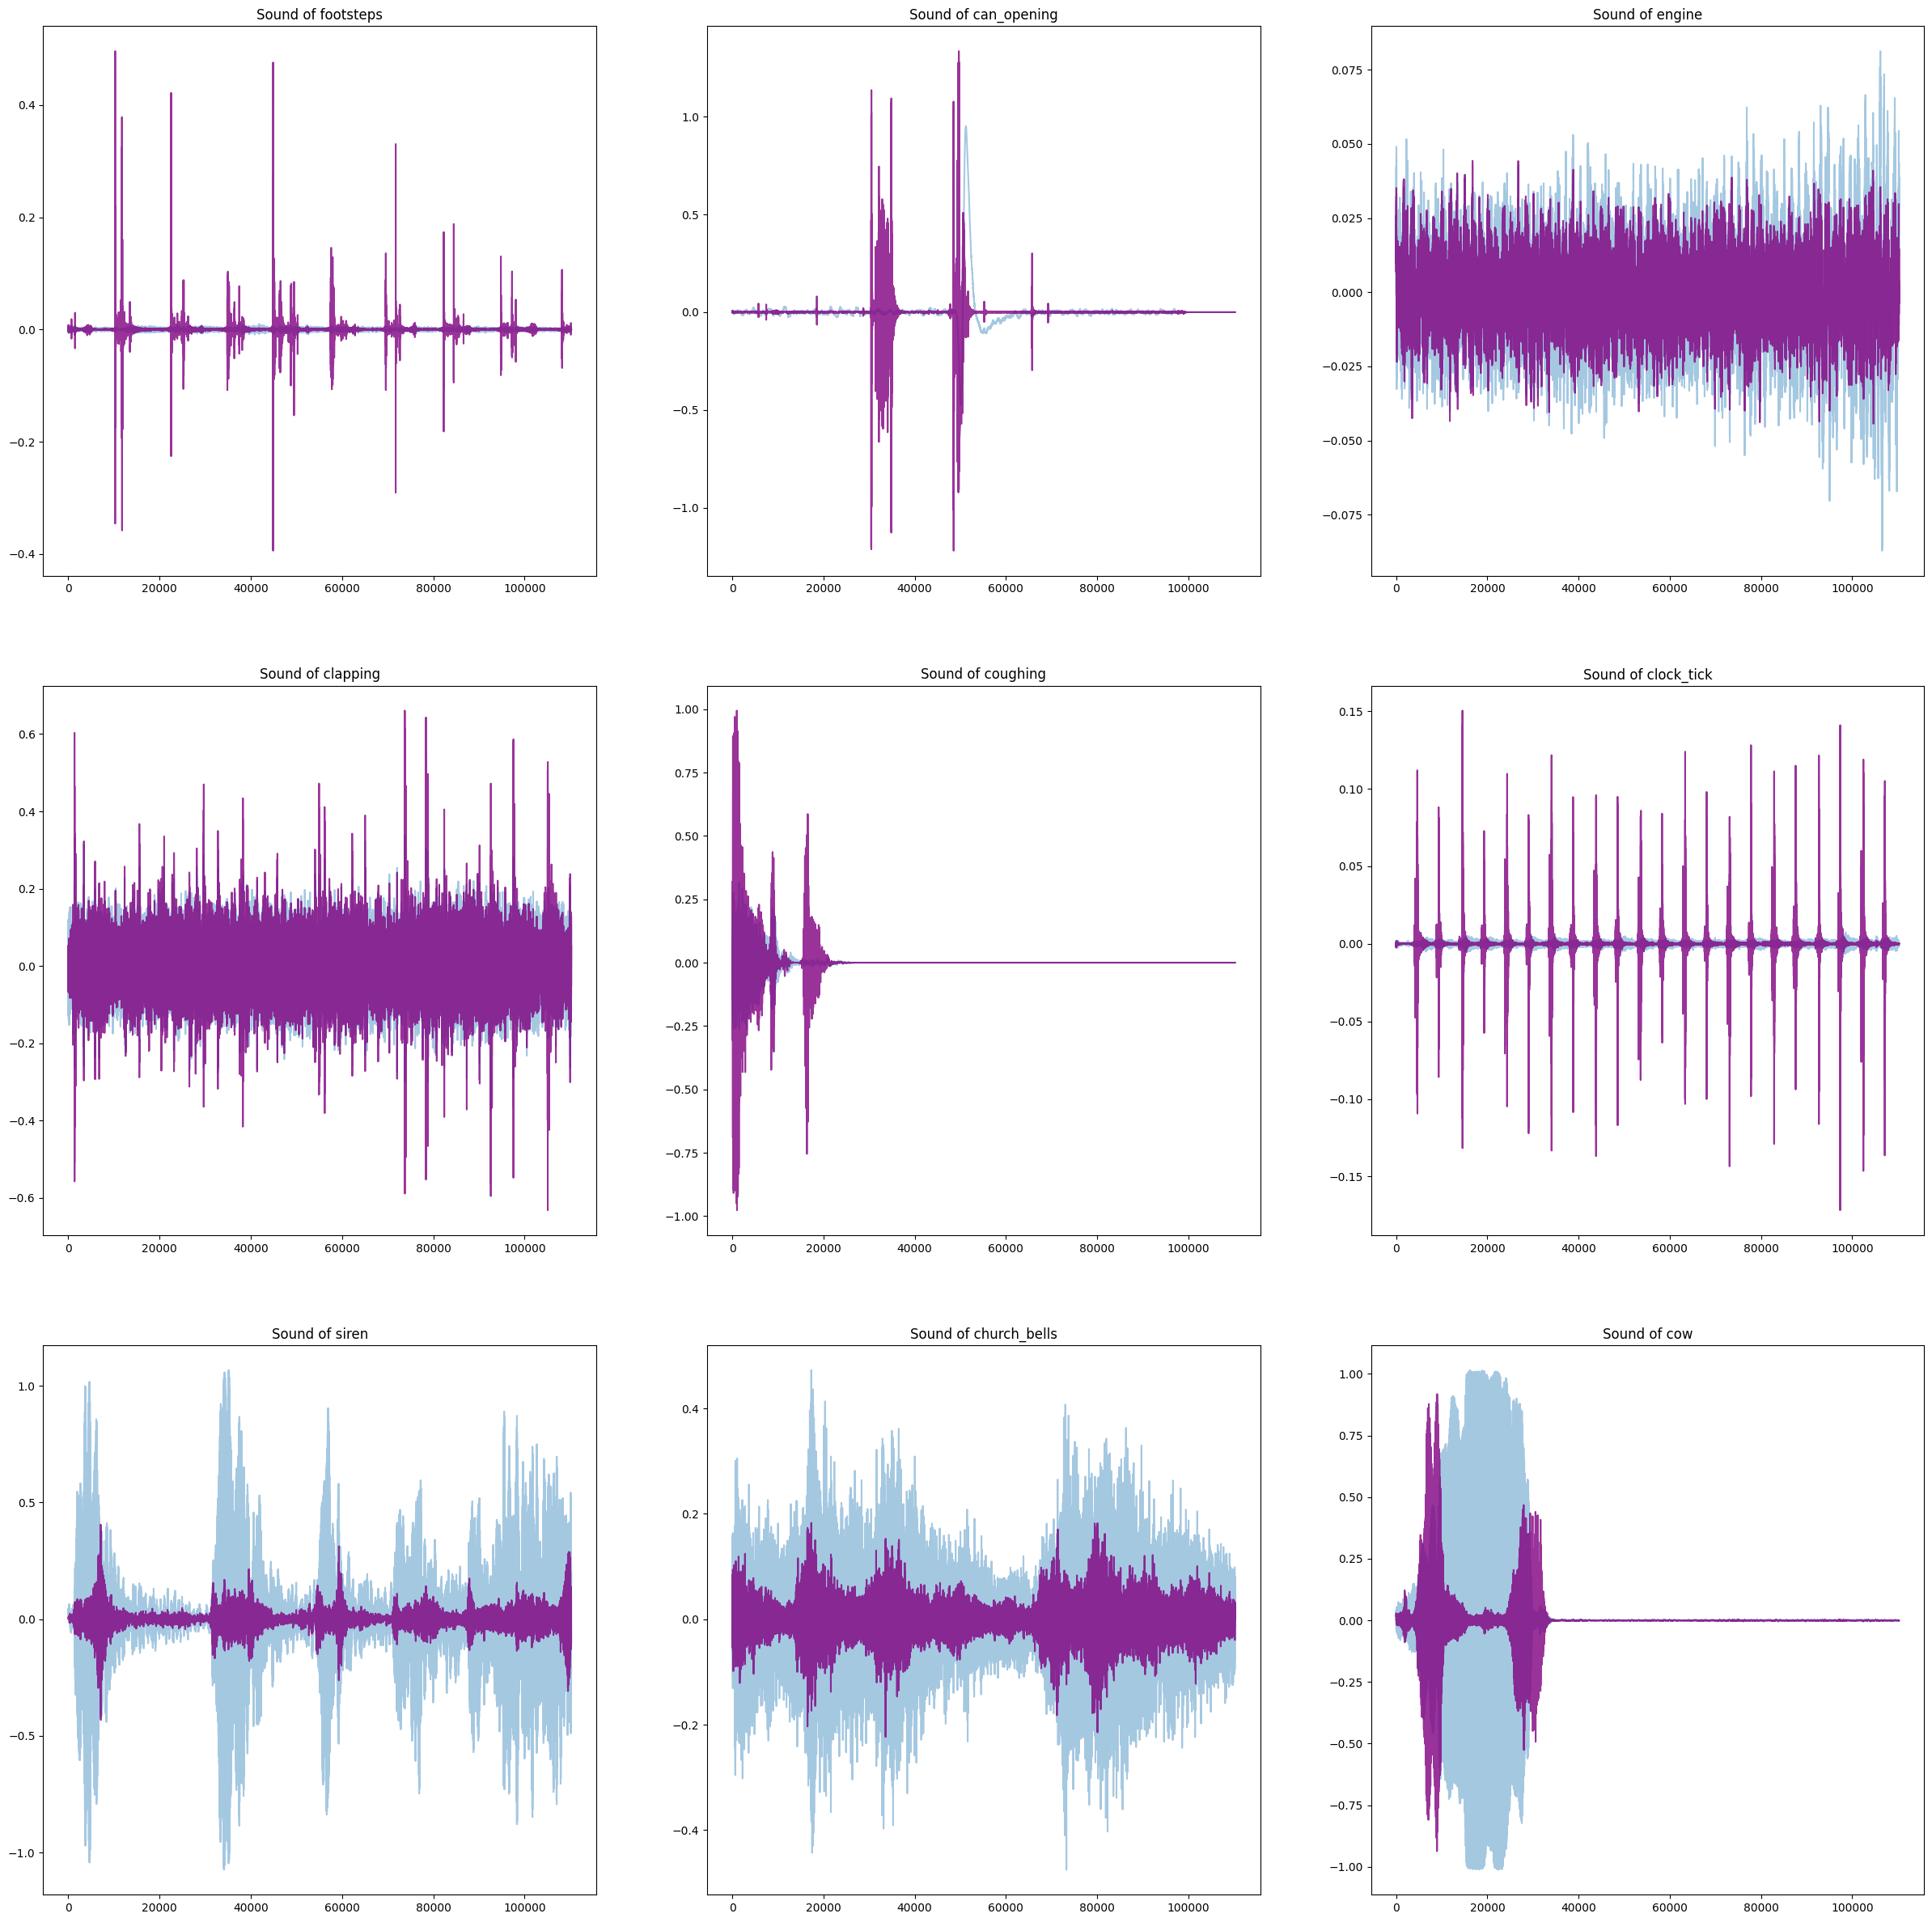

In [29]:
"""
This script uses Harmonic-Percussive Source Separation (HPSS) in librosa to decompose an audio signal into 
harmonic and percussive components, then visualizes them using waveform plots."
"""
plt.figure(figsize=(30,30))
for i in range(1,10):
    plt.subplot(3,3,i)
    y_harm, y_perc = librosa.effects.hpss(plot_audios[i][0])
    plt.plot(y_harm, alpha=0.4);
    plt.plot(y_perc, color = 'purple', alpha=0.8);
    try:
        plt.title("Sound of " + decoder[int(plot_files[i][-6:-4])] )
    except:
        plt.title("Sound of " + decoder[int(plot_files[i][-5:-4])] )

In [30]:
for i in range(1,10):
    tempo, _ = librosa.beat.beat_track(y=plot_audios[i][0], sr=plot_audios[i][1])
    
    file_path = plot_files[i]  # Đường dẫn gốc
    try:
        sound_label = decoder[int(plot_files[i][-6:-4])]
    except:
        sound_label = decoder[int(plot_files[i][-5:-4])]

    print('File path : ', file_path)
    print('Sound of ' + sound_label)
    print('BPM :', tempo)
    print('--------------------------')


File path :  ESC-50-master/audio\1-155858-B-25.wav
Sound of footsteps
BPM : [103.359375]
--------------------------
File path :  ESC-50-master/audio\2-130245-A-34.wav
Sound of can_opening
BPM : [75.99954044]
--------------------------
File path :  ESC-50-master/audio\2-106486-A-44.wav
Sound of engine
BPM : [99.38401442]
--------------------------
File path :  ESC-50-master/audio\4-189832-A-22.wav
Sound of clapping
BPM : [117.45383523]
--------------------------
File path :  ESC-50-master/audio\4-169726-A-24.wav
Sound of coughing
BPM : [89.10290948]
--------------------------
File path :  ESC-50-master/audio\5-209698-A-38.wav
Sound of clock_tick
BPM : [135.99917763]
--------------------------
File path :  ESC-50-master/audio\1-31482-A-42.wav
Sound of siren
BPM : [99.38401442]
--------------------------
File path :  ESC-50-master/audio\3-111102-A-46.wav
Sound of church_bells
BPM : [129.19921875]
--------------------------
File path :  ESC-50-master/audio\1-16568-A-3.wav
Sound of cow
BPM 

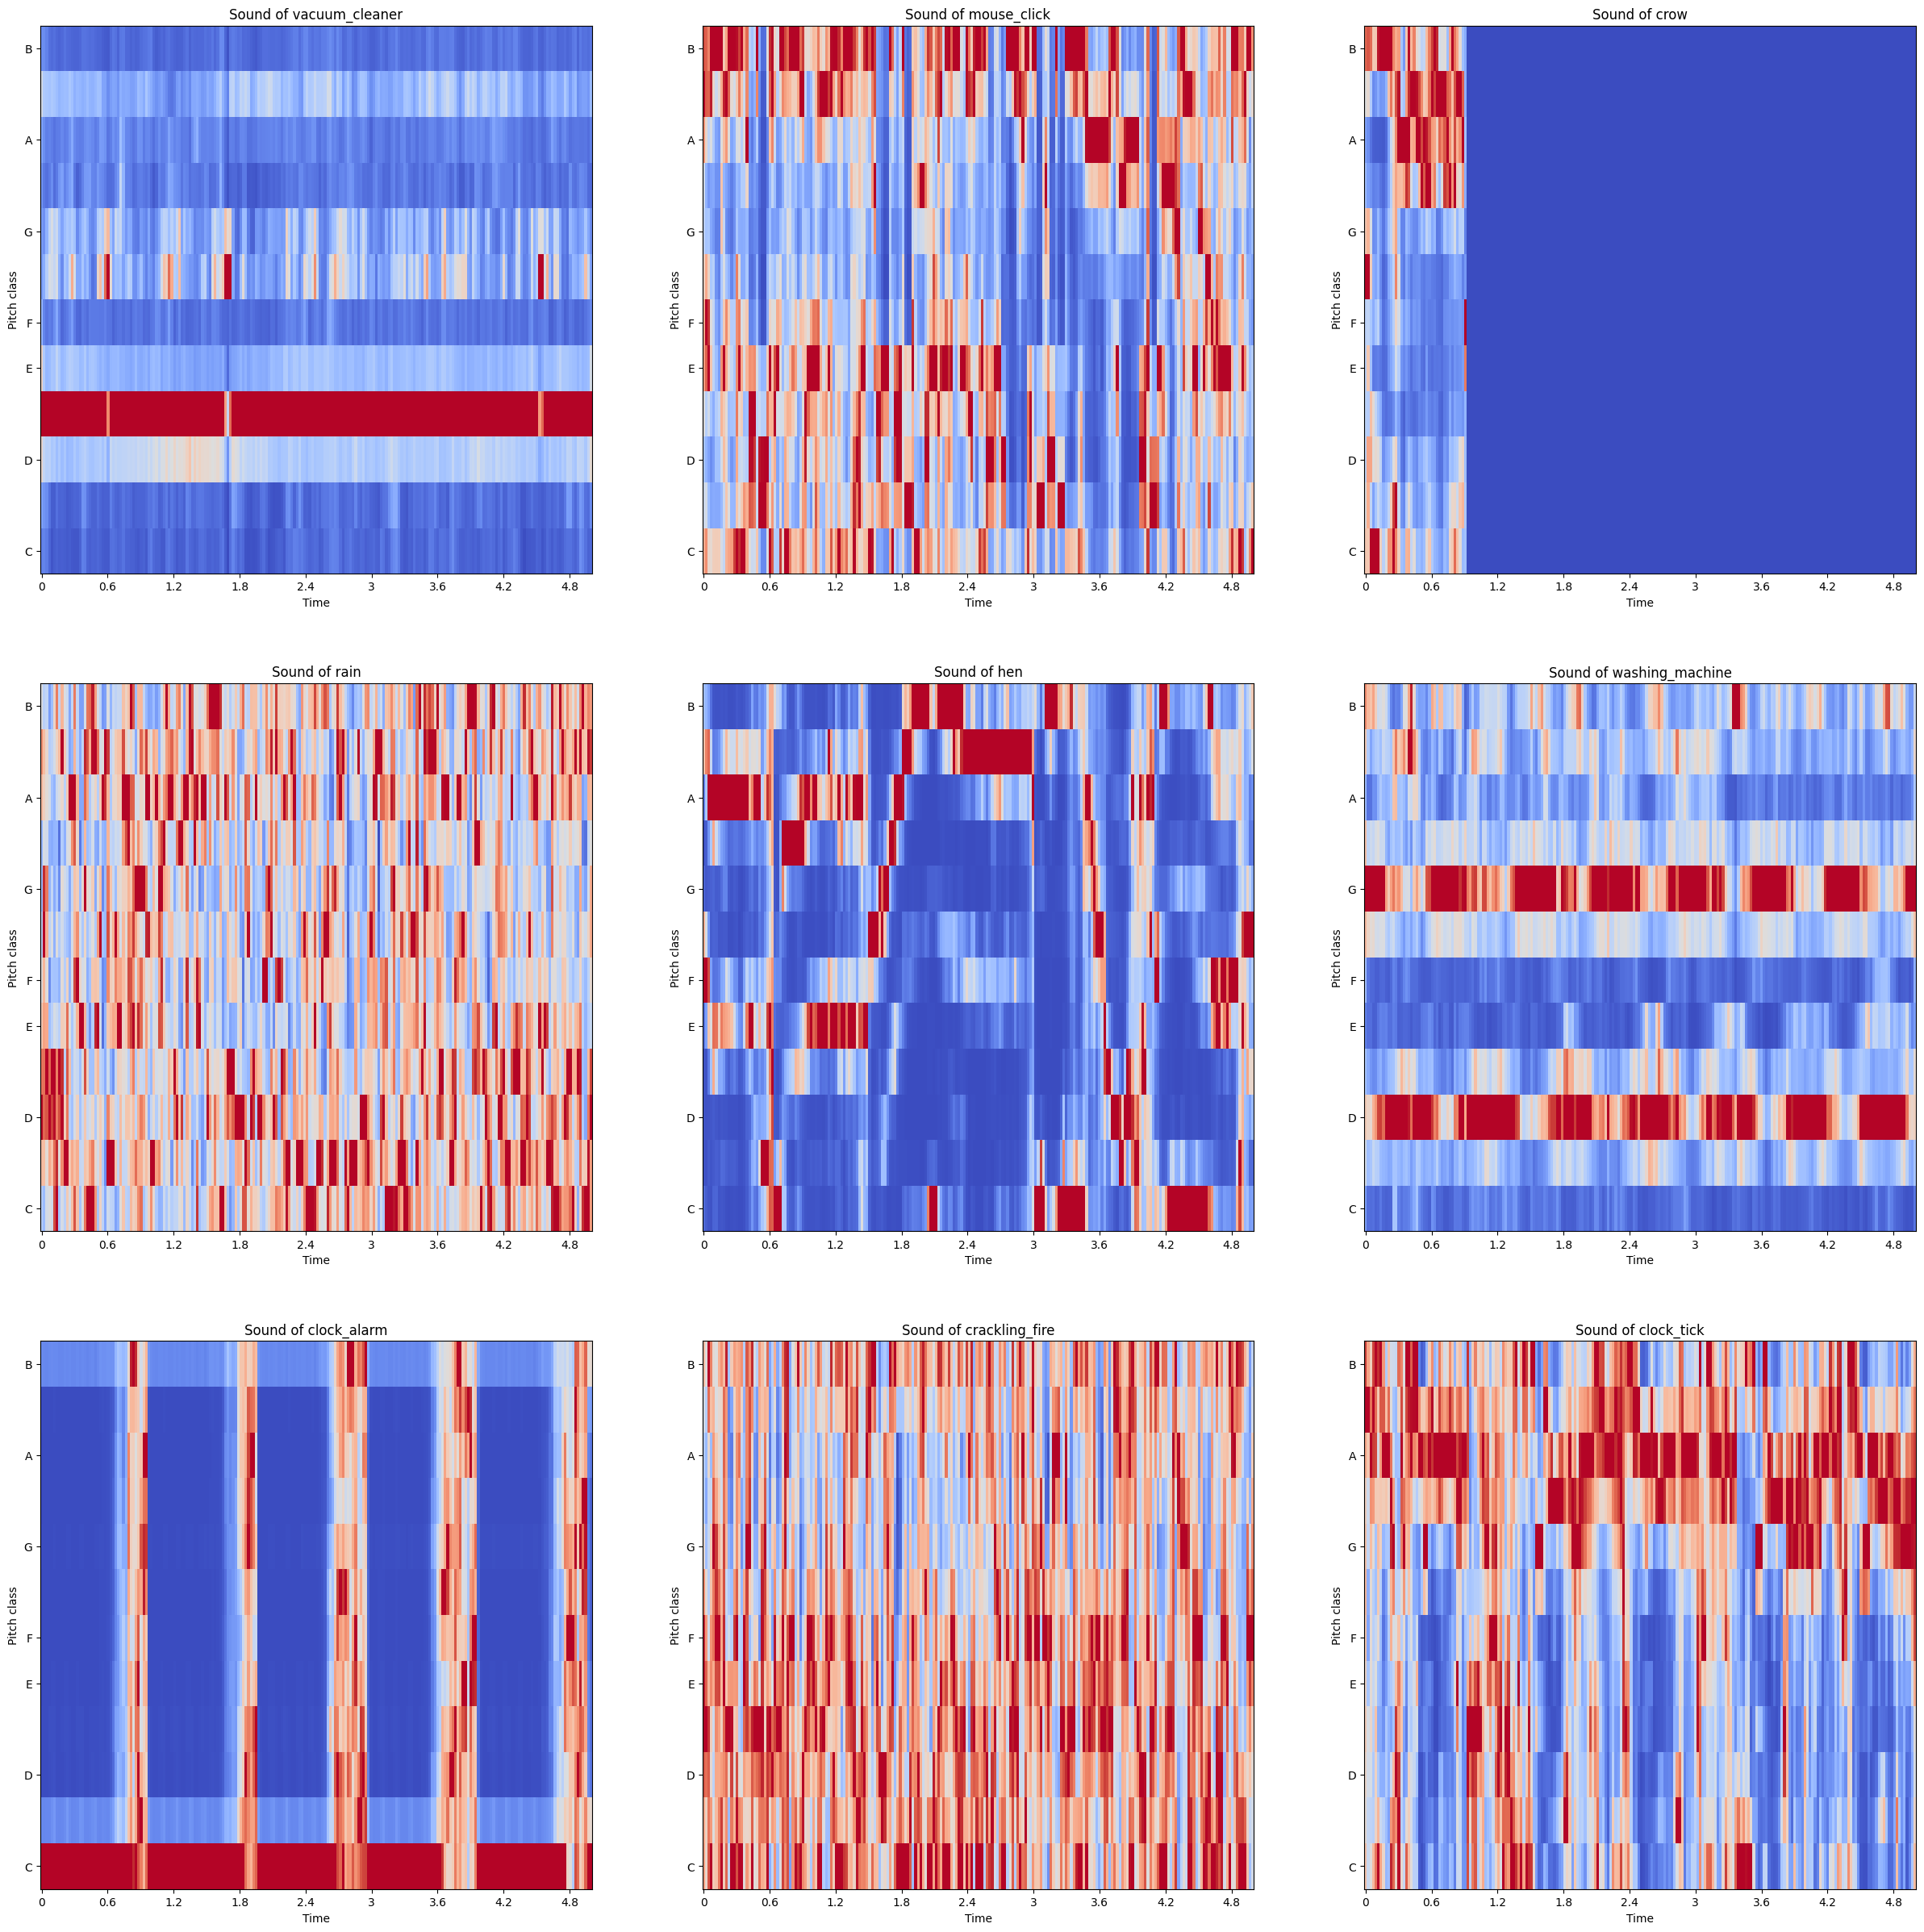

In [20]:
plt.figure(figsize=(30,30))
for i in range(1,10):
    plt.subplot(3,3,i)
    chromagram = librosa.feature.chroma_stft(y=plot_audios[i][0], sr=plot_audios[i][1], hop_length=hop_length)
    librosa.display.specshow(chromagram, x_axis='time', y_axis='chroma', hop_length=hop_length, cmap='coolwarm')
    try:
        plt.title("Sound of " + decoder[int(plot_files[i][-6:-4])] )
    except:
        plt.title("Sound of " + decoder[int(plot_files[i][-5:-4])] )

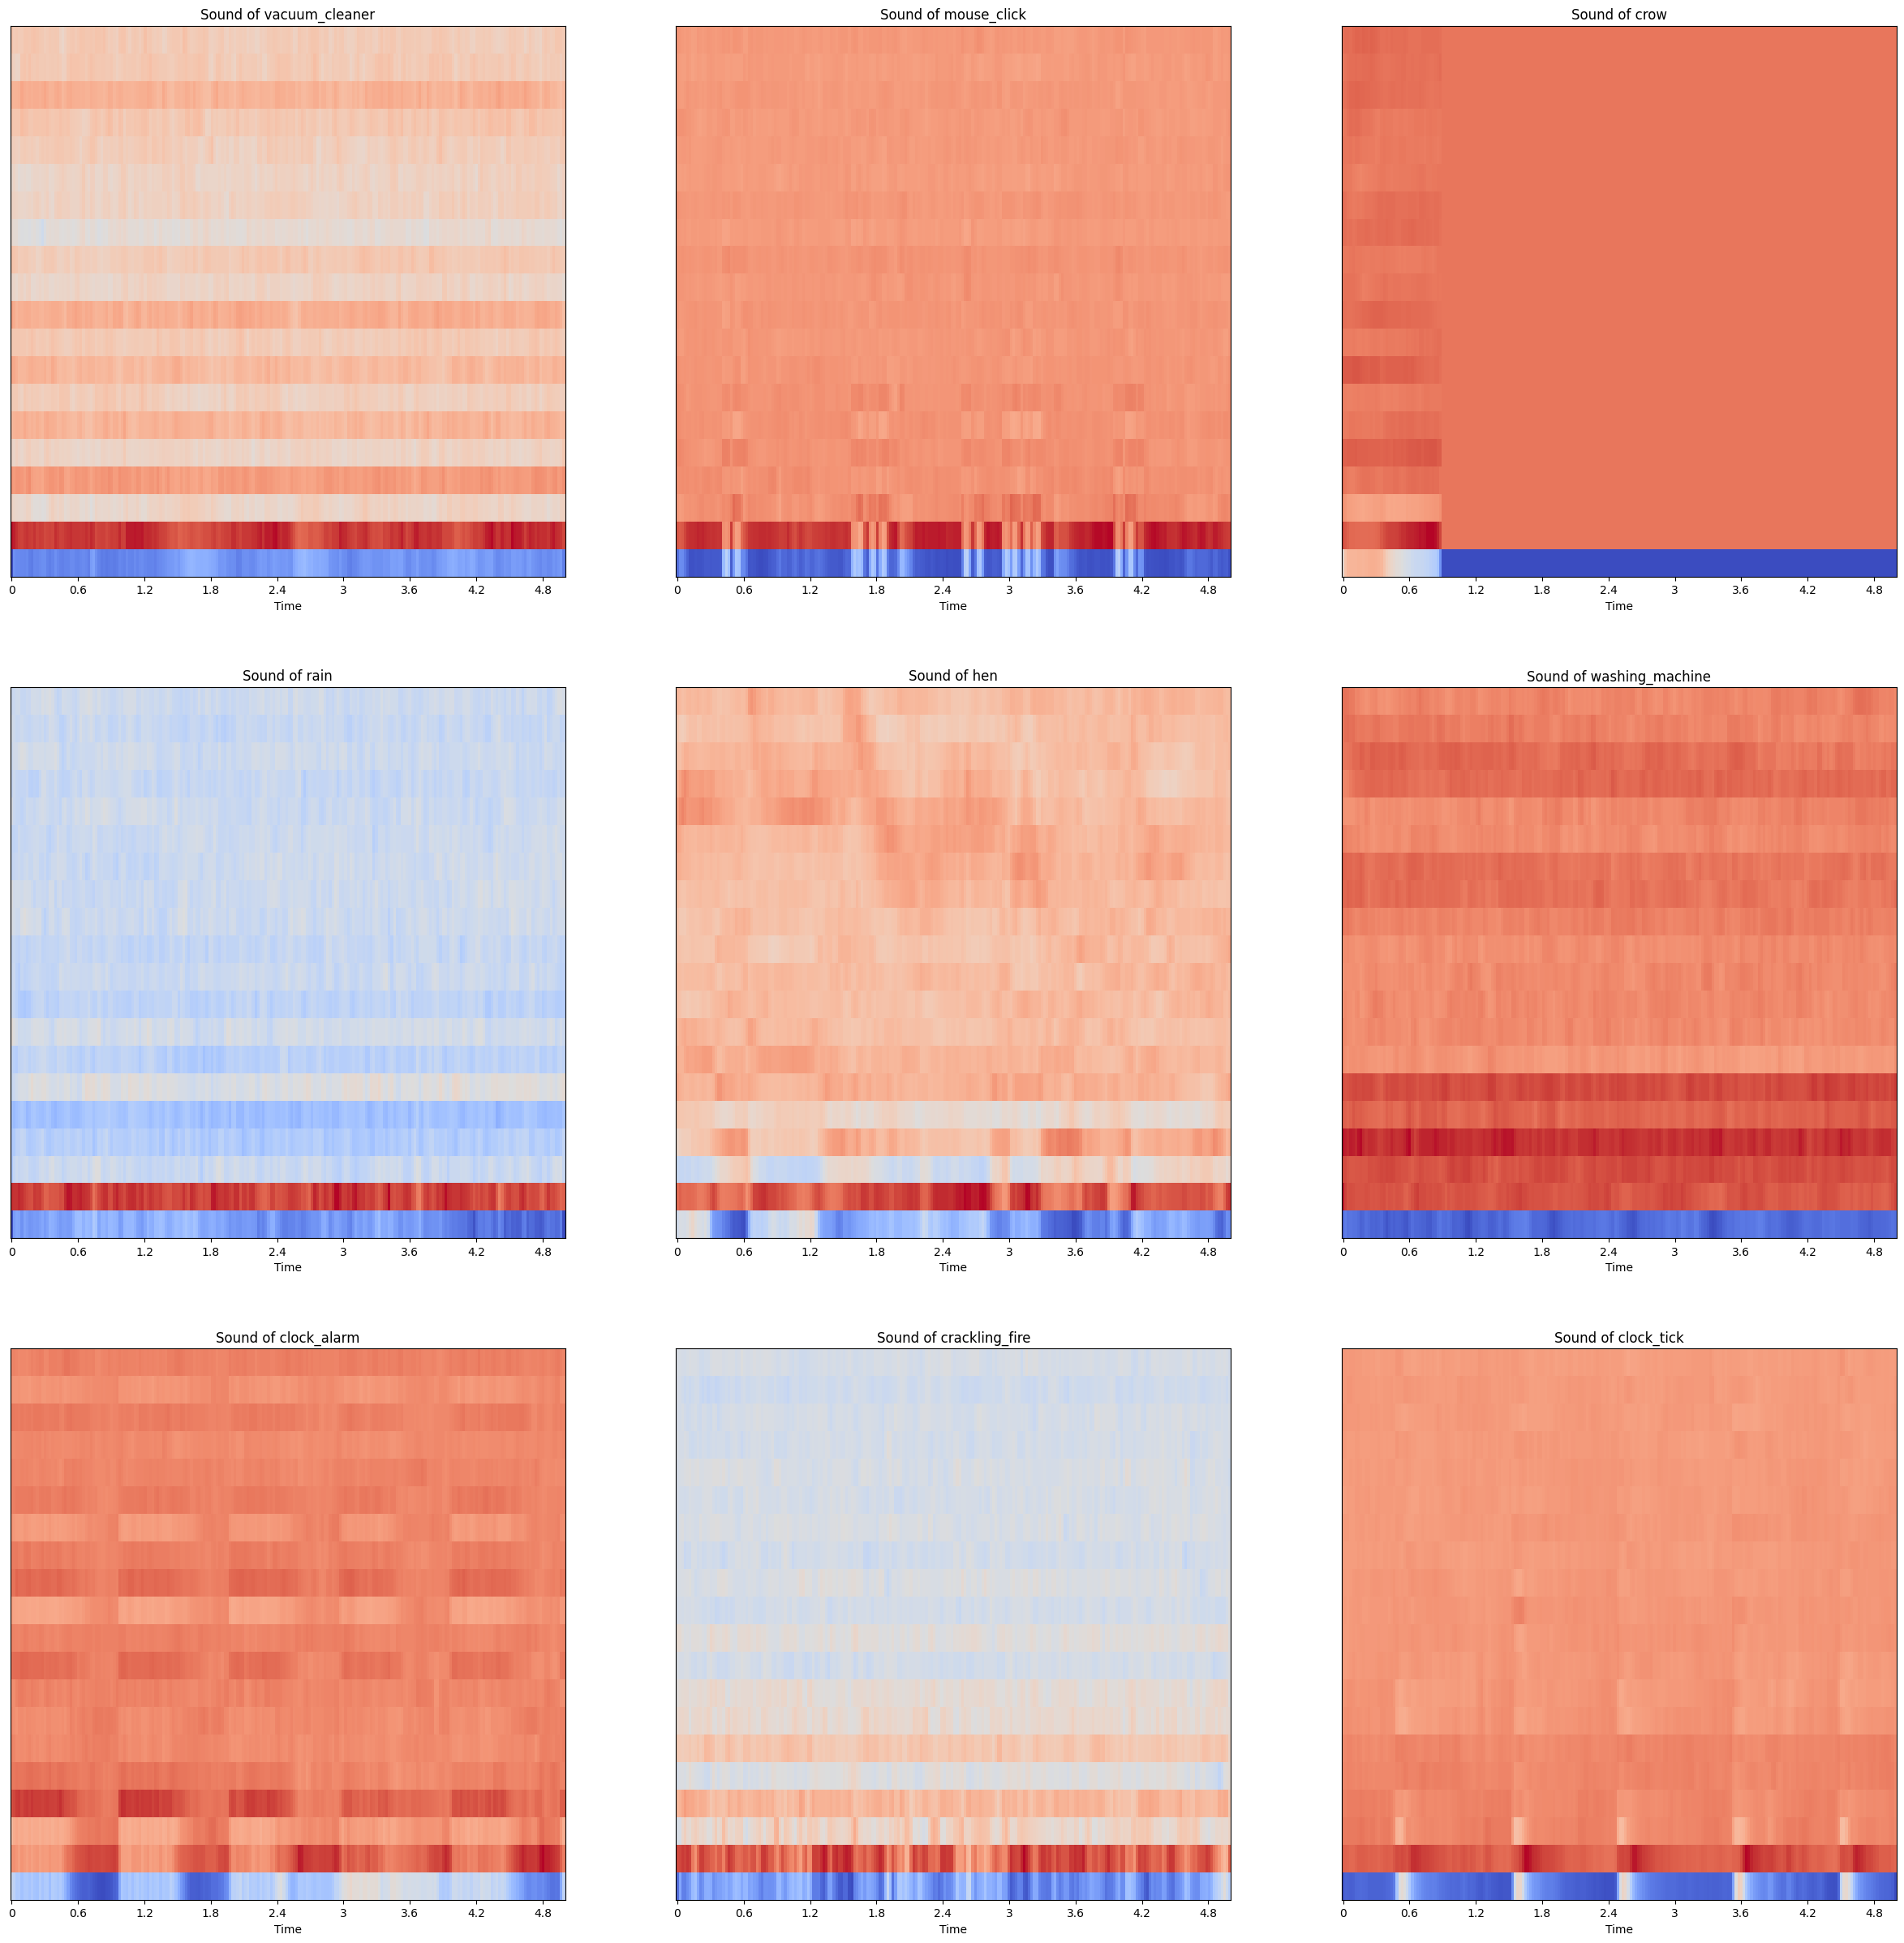

In [21]:
plt.figure(figsize=(30,30))
for i in range(1,10):
    plt.subplot(3,3,i)
    mfccs = librosa.feature.mfcc(y=plot_audios[i][0], sr=plot_audios[i][1])
    librosa.display.specshow(mfccs, sr=plot_audios[i][1], x_axis='time')
    try:
        plt.title("Sound of " + decoder[int(plot_files[i][-6:-4])] )
    except:
        plt.title("Sound of " + decoder[int(plot_files[i][-5:-4])] )

## **Data Augmention**

In [35]:
# create augmented folder 
os.makedirs(AUGMENTED_PATH, exist_ok=True)

In [36]:
# save augmented data 
def save_augmented_audio(filename, data, sr=16000):
   sf.write(filename, data, sr)

def add_noise(data):
    noise = np.random.normal(0, 0.02, len(data))
    return data + noise

def pitch_shifting(data, sr=16000):
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change = pitch_pm * 2 * (np.random.uniform())
    return librosa.effects.pitch_shift(data.astype(np.float32), sr=sr, n_steps=pitch_change, bins_per_octave=bins_per_octave)

def random_shift(data):
    shift = int(np.random.uniform(-0.2, 0.2) * len(data))
    return np.roll(data, shift)

def volume_scaling(data):
    return data * np.random.uniform(0.7, 1.3)

def time_stretching(data, rate=1.5):
    return librosa.effects.time_stretch(data.astype(np.float32), rate=rate)

def volume_change(data, gain=3):
   return data * (10**(gain / 20))

def add_time_delay(data, delay_samples=1000):
    """
    Adds a time delay to an audio signal.

    :param data: The original audio signal.
    :param delay_samples: The number of samples to delay the signal by.
    :return: The audio signal with the applied delay effect.
    """
    delayed_signal = np.zeros_like(data)
    delayed_signal[delay_samples:] = data[:-delay_samples]
    return data + 0.5 * delayed_signal  

In [37]:
print("\n🟢 Starting Data Augmentation...")  # Notify the start of data augmentation

augmented_files = []  # List to store paths of augmented audio files
augmented_targets = []  # List to store corresponding labels

# Iterate through each row in the dataset
for index, row in tqdm(dataset.iterrows(), total=len(dataset)):
    file_path = row["files_path"]  # Get the file path of the audio
    label = row["target"]  # Get the corresponding target label

    try:
        # Load the audio file with a sample rate of 16,000 Hz
        data, sr = librosa.load(file_path, sr=16000)

        # Apply various data augmentation techniques
        augmentations = [
            add_noise(data),  # Add Gaussian noise
            pitch_shifting(data, sr=sr),  # Apply pitch shifting
            random_shift(data),  # Apply random time shifting
            volume_scaling(data),  # Apply volume scaling
            time_stretching(data, rate=1.5),  # Apply time stretching
            volume_change(data, gain=3),  # Change volume by a gain of 3dB
            add_time_delay(data, delay_samples=1000)  # Add a time delay effect
        ]

        # Save the augmented audio files
        for idx, aug_data in enumerate(augmentations):
            aug_filename = f"{row['filename'][:-4]}.wav"  # Generate new filename
            aug_filepath = os.path.join(AUGMENTED_PATH, aug_filename)  # Define the save path
            save_augmented_audio(aug_filepath, aug_data, sr)  # Save the augmented audio

            # Store the augmented file path and its corresponding label
            augmented_files.append(aug_filepath)
            augmented_targets.append(label)

    except Exception as e:
        # Handle exceptions and print an error message
        print(f"⚠️ Error during data augmentation for file {file_path}: {e}")


🟢 Starting Data Augmentation...


100%|██████████| 2000/2000 [02:15<00:00, 14.76it/s]


In [38]:
dataset_aug = pd.DataFrame({"files_path": augmented_files, "target": augmented_targets})
dataset = pd.concat([dataset, dataset_aug], ignore_index=True)
print(f"\n🟢 Total number of samples after augmentation: {len(dataset)}")  


🟢 Total number of samples after augmentation: 16000


In [39]:
dataset.shape

(16000, 8)

## **Pre-Processing Data**

In [40]:
# extract sound feature
features = [
    'zero_crossing_rate', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth',
    'beat_per_minute', 'rolloff', 'spectral_contrast', 'tonnetz', 'spectral_flatness',
    'mel_spectrogram', 'chroma_cens'
] + [f'mfcc_{i}' for i in range(64)]

for feature in features:
    dataset[feature] = np.zeros(len(dataset))

for i in tqdm(range(len(dataset))):
    file_path = dataset['files_path'][i]
    
    if os.path.exists(file_path):
        y, sr = librosa.load(file_path, mono=True)

        if len(y) > 0:
            try:
                # extract features
                dataset.at[i, 'rmse'] = np.mean(librosa.feature.rms(y=y))
                dataset.at[i, 'chroma_stft'] = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))
                dataset.at[i, 'spectral_centroid'] = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
                dataset.at[i, 'spectral_bandwidth'] = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
                dataset.at[i, 'rolloff'] = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
                dataset.at[i, 'zero_crossing_rate'] = np.mean(librosa.feature.zero_crossing_rate(y))
                dataset.at[i, 'spectral_contrast'] = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr))
                dataset.at[i, 'tonnetz'] = np.mean(librosa.feature.tonnetz(y=y, sr=sr))
                dataset.at[i, 'spectral_flatness'] = np.mean(librosa.feature.spectral_flatness(y=y))
                dataset.at[i, 'mel_spectrogram'] = np.mean(librosa.feature.melspectrogram(y=y, sr=sr))
                dataset.at[i, 'chroma_cens'] = np.mean(librosa.feature.chroma_cens(y=y, sr=sr))
                tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
                dataset.at[i, 'beat_per_minute'] = tempo

                # extract mel-spectrogram
                mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000)
                log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  

                for e in range(64):
                    dataset.at[i, f'mfcc_{e}'] = np.mean(log_mel_spec[e])
            
            except Exception as e:
                print(f"Error when extract feature from {file_path}: {e}")

        else:
            print(f"Empty file: {file_path}")

mfcc_features = [f'mfcc_{i}' for i in range(64)]
scaler = StandardScaler()
dataset[mfcc_features] = scaler.fit_transform(dataset[mfcc_features])

  0%|          | 0/16000 [00:00<?, ?it/s]

  1%|          | 109/16000 [00:23<53:09,  4.98it/s] c:\Users\fury14\miniconda3\envs\audio\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
100%|██████████| 16000/16000 [55:26<00:00,  4.81it/s] 


In [41]:
dataset.shape

(16000, 84)

#### **Ensure all data have splitted two five fold, each fold has 3200 sample**

In [ ]:
import pandas as pd
import numpy as np


# Count the number of existing samples for each fold (from 1 to 5)
fold_counts = dataset['fold'].value_counts().to_dict()

# Define the target count for each fold (total 16,000 samples, 3,200 per fold)
target_fold_count = 3200
all_folds = [1, 2, 3, 4, 5]

# Ensure all folds exist in the dictionary, initializing missing ones with 0
for f in all_folds:
    fold_counts.setdefault(f, 0)

# Calculate the number of missing samples for each fold
missing_counts = {f: target_fold_count - fold_counts[f] for f in all_folds}

# Get the indices of rows where the 'fold' column is missing
missing_indices = dataset[dataset['fold'].isna()].index
num_missing = len(missing_indices)

# Generate a list of fold values to fill, ensuring the correct number for each fold
fill_values = []
for f, count in missing_counts.items():
    fill_values.extend([f] * count)

# Shuffle the values to ensure random distribution
np.random.shuffle(fill_values)

# Assign the generated fold values to the missing rows
dataset.loc[missing_indices, 'fold'] = fill_values

# Save the updated dataset to a new CSV file if needed
dataset.to_csv("dataset.csv", index=False)

# Verify the number of samples in each fold
print(dataset['fold'].value_counts())

#### **Train-Test split**

In [5]:
# train = dataset.sample(frac=0.8, random_state=SEED)
# test = dataset.drop(train.index)
# X_train = train[features]
# X_test = test[features]
# y_train = train['target']
# y_test = test['target']
# scaler = StandardScaler()
# X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
# X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

features = [
    'zero_crossing_rate', 'chroma_stft', 'rmse', 'spectral_centroid', 'spectral_bandwidth',
    'beat_per_minute', 'rolloff', 'spectral_contrast', 'tonnetz', 'spectral_flatness',
    'mel_spectrogram', 'chroma_cens'
] + [f'mfcc_{i}' for i in range(64)]

In [3]:
df = pd.read_csv("dataset.csv")
df_test = df[df["fold"]== 1.0]
df_train = df[df["fold"] != 1.0]

C:\Users\fury14\AppData\Local\Temp\ipykernel_27372\2828117804.py:1: DtypeWarning: Columns (0,3,4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("dataset.csv")


In [6]:
X_train = df_train[features]
X_test = df_test[features]
y_train = df_train['target']
y_test = df_test['target']

## **Training**

In [8]:
# initialize model 
model_builder = NNModel(
    input_shape= (X_train.shape[1], ),
    num_classes= 50
)

# model dict to contain models 
models_dict = {
    "CNN": model_builder.build_cnn(),
    "LSTM": model_builder.build_lstm(),
    "CNN_LSTM": model_builder.build_cnn_lstm(),
    "BiLSTM": model_builder.build_bilstm()
}

c:\Users\fury14\miniconda3\envs\audio\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
cnn_model = model_builder.build_cnn() 
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_4 (Reshape)             │ (None, 76, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 76, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 76, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 38, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 38, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 38, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 19, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 19, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 19, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 9, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 50)             │        12,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,003,442 (11.46 MB)

 Trainable params: 3,000,114 (11.44 MB)

 Non-trainable params: 3,328 (13.00 KB)

In [10]:
lstm_model =  model_builder.build_lstm() 
lstm_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 76)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 76, 1)     │          0 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 76, 128)   │        512 │ reshape_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 76, 128)   │        512 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 38, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 38, 256)   │     98,560 │ max_pooling1d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 38, 256)   │      1,024 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_12    │ (None, 19, 256)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 19, 256)   │    525,312 │ max_pooling1d_12… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 256)   │      1,024 │ lstm_8[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 19, 128)   │    197,120 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 19, 128)   │        512 │ lstm_9[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 19, 1)     │        129 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 19)        │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 19)        │          0 │ flatten_3[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 128, 19)   │          0 │ activation_1[0][… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute_1 (Permute) │ (None, 19, 128)   │          0 │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 19, 128)   │          0 │ batch_normalizat… │
│ (Multiply)          │                   │            │ permute_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ multiply_1[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 848,179 (3.24 MB)

 Trainable params: 846,387 (3.23 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [11]:
cnn_lstm_model =  model_builder.build_cnn_lstm()
cnn_lstm_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 76)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 76, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 76, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 38, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 38, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 19, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 19, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 9, 512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 9, 256)         │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 9, 128)         │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 50)             │         6,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,541,554 (5.88 MB)

 Trainable params: 1,541,554 (5.88 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
start_time = time.time()
results = []
save_dir = "trained_models"
os.makedirs(save_dir, exist_ok=True)  # save model 

# train and save model 
for name, model in models_dict.items():
    print(f"\n🔵 Training {name}...")

    # train model 
    history = model.fit(
        X_train, 
        y_train, 
        epochs=100, 
        batch_size=32, 
        validation_data=(X_test, y_test), verbose=1
    )

    # training information 
    train_acc = history.history['accuracy'][-1]  
    train_loss = history.history['loss'][-1]      
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    results.append({
        "Model": name,
        "Train Accuracy": train_acc,
        "Train Loss": train_loss,
        "Test Accuracy": test_acc,
        "Test Loss": test_loss
    })

    model_path = os.path.join(save_dir, f"{name}.h5") 
    model.save(model_path)
    print(f"✅ Model {name} saved at {model_path}.!")
print(f"Time for training: {time.time() - start_time}")



🔵 Training CNN...
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.0679 - loss: 4.5004 - val_accuracy: 0.1587 - val_loss: 3.3519
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.1366 - loss: 3.7137 - val_accuracy: 0.2706 - val_loss: 2.7719
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - accuracy: 0.1695 - loss: 3.3989 - val_accuracy: 0.3294 - val_loss: 2.5339
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.2111 - loss: 3.0809 - val_accuracy: 0.3703 - val_loss: 2.3545
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.2450 - loss: 2.8718 - val_accuracy: 0.4144 - val_loss: 2.1427
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - accuracy: 0.2929 - loss: 2.6123 - val_accuracy: 0.3956 - val_loss: 2.1497
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 17s 41ms/step - accuracy: 0.3284 - loss: 2.4340 - val_accuracy: 0.5312 - val_loss: 1.7812
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accurac

✅ Model CNN saved at trained_models\CNN.h5.!

🔵 Training LSTM...
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 33s 68ms/step - accuracy: 0.0695 - loss: 3.6734 - val_accuracy: 0.1075 - val_loss: 3.5645
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 29s 73ms/step - accuracy: 0.1643 - loss: 3.0368 - val_accuracy: 0.2631 - val_loss: 2.6207
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 27s 69ms/step - accuracy: 0.2451 - loss: 2.6941 - val_accuracy: 0.2931 - val_loss: 2.4455
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - accuracy: 0.2849 - loss: 2.5105 - val_accuracy: 0.3416 - val_loss: 2.2920
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 27s 67ms/step - accuracy: 0.3426 - loss: 2.3076 - val_accuracy: 0.4272 - val_loss: 1.9512
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 27s 67ms/step - accuracy: 0.3904 - loss: 2.0874 - val_accuracy: 0.4631 - val_loss: 1.8464
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 27s 68ms/step - accuracy: 0.4496 - loss: 1.8651 - val_accuracy: 0.5509 - val_loss: 1.5027
Epoch 8/100
400/40

✅ Model LSTM saved at trained_models\LSTM.h5.!

🔵 Training CNN_LSTM...
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.0417 - loss: 3.7691 - val_accuracy: 0.1222 - val_loss: 3.2811
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.1027 - loss: 3.2784 - val_accuracy: 0.2175 - val_loss: 2.8579
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.1955 - loss: 2.9108 - val_accuracy: 0.2856 - val_loss: 2.5066
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.2587 - loss: 2.5669 - val_accuracy: 0.3631 - val_loss: 2.2143
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.3291 - loss: 2.2875 - val_accuracy: 0.4128 - val_loss: 1.9272
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.3885 - loss: 2.0934 - val_accuracy: 0.5122 - val_loss: 1.6975
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.4442 - loss: 1.8755 - val_accuracy: 0.5725 - val_loss: 1.4261
Epoch 8/100


✅ Model CNN_LSTM saved at trained_models\CNN_LSTM.h5.!

🔵 Training BiLSTM...
Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 90s 210ms/step - accuracy: 0.0538 - loss: 3.7162 - val_accuracy: 0.1287 - val_loss: 3.1523
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 84s 210ms/step - accuracy: 0.1190 - loss: 3.2187 - val_accuracy: 0.2428 - val_loss: 2.8041
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 83s 209ms/step - accuracy: 0.1826 - loss: 2.9475 - val_accuracy: 0.2353 - val_loss: 2.6557
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 83s 209ms/step - accuracy: 0.2328 - loss: 2.7600 - val_accuracy: 0.2759 - val_loss: 2.5584
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 84s 210ms/step - accuracy: 0.2798 - loss: 2.5556 - val_accuracy: 0.3738 - val_loss: 2.1579
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 81s 204ms/step - accuracy: 0.3170 - loss: 2.3668 - val_accuracy: 0.3559 - val_loss: 2.1768
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 67s 167ms/step - accuracy: 0.3471 - loss: 2.2433 - val_accuracy: 0.3684 - val_loss: 2.0982

✅ Model BiLSTM saved at trained_models\BiLSTM.h5.!
Time for training: 12980.486102581024


In [13]:
results

[{'Model': 'CNN',
  'Train Accuracy': 0.9920312762260437,
  'Train Loss': 0.027370555326342583,
  'Test Accuracy': 0.9981250166893005,
  'Test Loss': 0.004840333014726639},
 {'Model': 'LSTM',
  'Train Accuracy': 0.9661718606948853,
  'Train Loss': 0.10659302026033401,
  'Test Accuracy': 0.9981250166893005,
  'Test Loss': 0.005775578785687685},
 {'Model': 'CNN_LSTM',
  'Train Accuracy': 0.9646093845367432,
  'Train Loss': 0.11917366832494736,
  'Test Accuracy': 0.9946874976158142,
  'Test Loss': 0.015968933701515198},
 {'Model': 'BiLSTM',
  'Train Accuracy': 0.8728906512260437,
  'Train Loss': 0.47085848450660706,
  'Test Accuracy': 0.6331250071525574,
  'Test Loss': 2.458519220352173}]

In [23]:
# save training results 
import csv

save_path = "training_results.csv"

with open(save_path, mode="w", newline="") as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=results[0].keys())
    writer.writeheader()
    writer.writerows(results)

print(f"Training results saved to {save_path}")

✅ Training results saved to training_results.csv


In [14]:
import json

save_path = "training_results.json"

with open(save_path, "w") as json_file:
    json.dump(results, json_file, indent=4)  

print(f"Training results saved to {save_path}")

Training results saved to training_results.json
